CSV Loaded Successfully!
New dataframe shape: (8760, 23)
        Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0 2017-12-01                254     0             -5.2           37   
1 2017-12-01                204     1             -5.5           38   
2 2017-12-01                173     2             -6.0           39   
3 2017-12-01                107     3             -6.2           40   
4 2017-12-01                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  ...  Functioning Day Day  Month  \
0                      0.0    

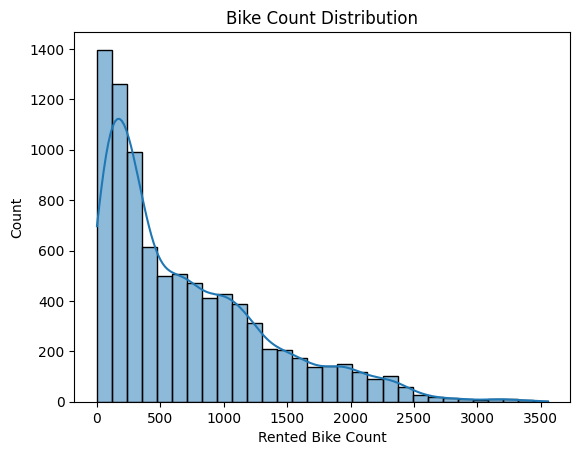

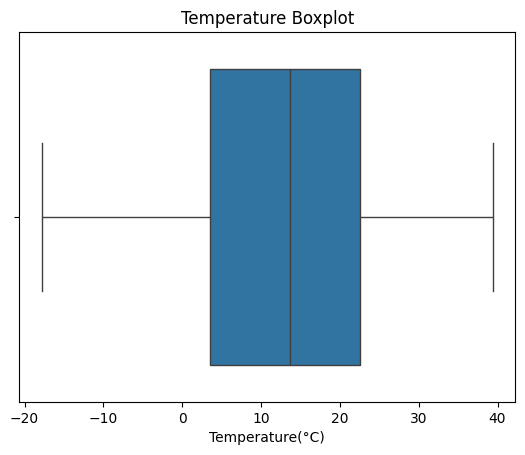


Top Correlations with Rented Bike Count:
Rented Bike Count            1.000000
feels_like_temp              0.579992
Temperature(°C)              0.538558
Hour                         0.410257
Dew point temperature(°C)    0.379788
is_evening_peak              0.361804
Solar Radiation (MJ/m2)      0.261837
Functioning Day              0.203943
Visibility (10m)             0.199280
WeekOfYear                   0.134311
Wind speed (m/s)             0.121108
is_morning_peak             -0.003969
is_weekend                  -0.036467
Holiday                     -0.072338
Rainfall(mm)                -0.123074
Snowfall (cm)               -0.141804
Humidity(%)                 -0.199780
is_low_demand_hour          -0.370501
Name: Rented Bike Count, dtype: float64


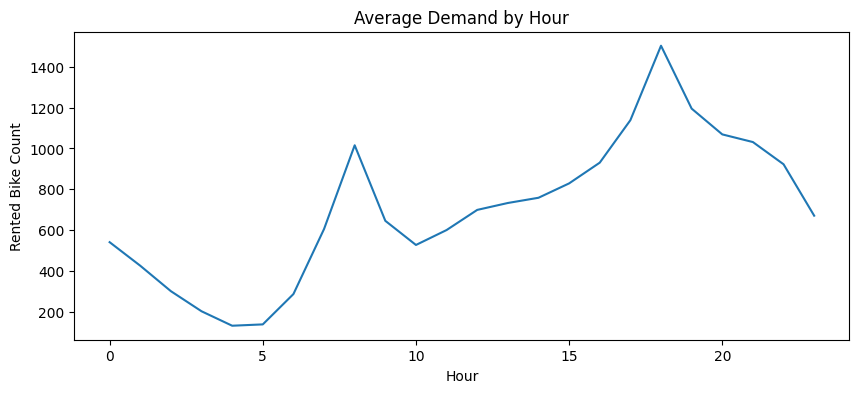

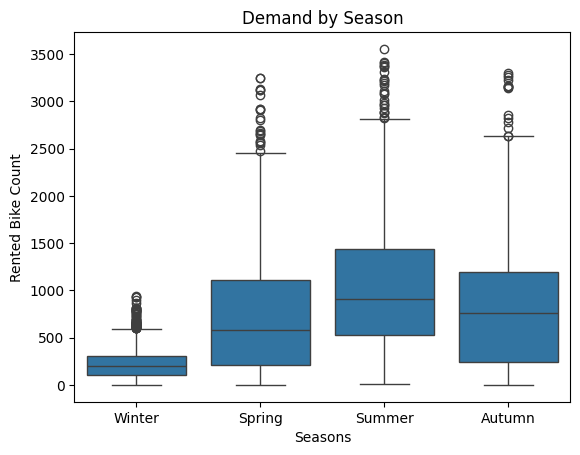


Correlation with Target Variable:
Rented Bike Count            1.000000
feels_like_temp              0.579992
Temperature(°C)              0.538558
Hour                         0.410257
Dew point temperature(°C)    0.379788
is_evening_peak              0.361804
Solar Radiation (MJ/m2)      0.261837
Functioning Day              0.203943
Visibility (10m)             0.199280
WeekOfYear                   0.134311
Month                        0.133514
Wind speed (m/s)             0.121108
Day                          0.022291
is_morning_peak             -0.003969
DayOfWeek                   -0.029357
is_weekend                  -0.036467
Holiday                     -0.072338
Rainfall(mm)                -0.123074
Snowfall (cm)               -0.141804
Humidity(%)                 -0.199780
is_low_demand_hour          -0.370501
Name: Rented Bike Count, dtype: float64


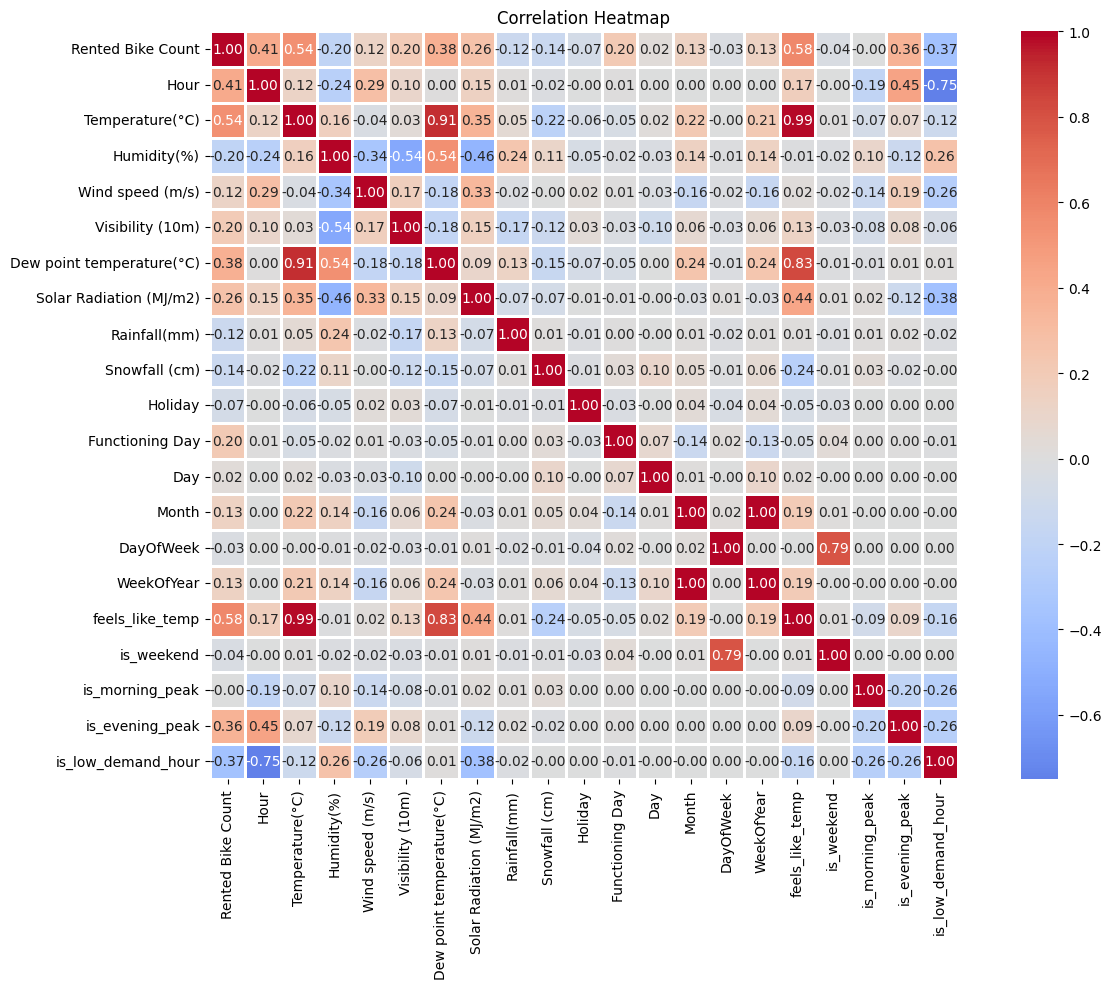

In [1]:
# ==========================================
# 1. Load Libraries
# ==========================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ==========================================
# 2. Load Dataset from CSV
# ==========================================
df = pd.read_csv('SeoulBikeData.csv', encoding= 'latin1')   # <-- Replace with your file name
print("CSV Loaded Successfully!")
target_col ='Rented Bike Count'

# ==========================================
# 3. Feature Engineering Function
# ==========================================
def add_engineered_features(df):

    # --- Fix Date Column ---
    df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)

    # Extract date parts
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)


    # --- Weather Interaction Features ---
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])

    # --- Flags (Weekend, Peak Hours) ---
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)

    # --- Binary Conversion ---
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})

    # Drop NaNs created from lags/rolling
    df = df.dropna().reset_index(drop=True)

    return df


# ==========================================
# 4. Apply Feature Engineering
# ==========================================
df = add_engineered_features(df)
print("New dataframe shape:", df.shape)
print(df.head())


# ==========================================
# 5. EDA Section
# ==========================================

# ---- Overview ----
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())

# ---- Summary ----
print("\nSummary Statistics:")
print(df.describe())

# ---- Outlier Detection ----
def outlier_count(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    return len(outliers)

for col in ['Rented Bike Count','Wind speed (m/s)','Solar Radiation (MJ/m2)','Rainfall(mm)','Snowfall (cm)']:
    print(f"{col} outliers:", outlier_count(col))

# ---- Distribution ----
sns.histplot(df['Rented Bike Count'], bins=30, kde=True)
plt.title('Bike Count Distribution')
plt.show()

sns.boxplot(x=df['Temperature(°C)'])
plt.title('Temperature Boxplot')
plt.show()

# ---- Correlation Matrix ----
numeric_df = df.select_dtypes(include=['int64','float64'])
corr = numeric_df.corr()

print("\nTop Correlations with Rented Bike Count:")
print(corr['Rented Bike Count'].sort_values(ascending=False))

# ---- Seasonality Plots ----
plt.figure(figsize=(10,4))
sns.lineplot(
    data=df.groupby('Hour')['Rented Bike Count'].mean().reset_index(),
    x='Hour', y='Rented Bike Count'
)
plt.title('Average Demand by Hour')
plt.show()

sns.boxplot(x='Seasons', y='Rented Bike Count', data=df)
plt.title('Demand by Season')
plt.show()

# Correlation matrix
correlation_matrix = df.corr(numeric_only=True)

print("\nCorrelation with Target Variable:")
target_corr = correlation_matrix[target_col].sort_values(ascending=False)
print(target_corr)

# Heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1)
plt.title('Correlation Heatmap')
plt.tight_layout()
plt.show()


In [4]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 1. Feature selection (same as before)
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 
    'is_evening_peak', 'is_low_demand_hour', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day'
]

X = df[feature_cols].values.astype(np.float32)
y = df[target_col].values.astype(np.float32)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# PyTorch expects (samples, seq_len, features)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert numpy arrays to torch tensors
X_train_torch = torch.from_numpy(X_train)
y_train_torch = torch.from_numpy(y_train).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test)
y_test_torch = torch.from_numpy(y_test).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 2. Define LSTM-GRU Hybrid Model
class LSTMGRUHybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden=64, gru_hidden=32):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden, batch_first=True)
        self.gru = nn.GRU(lstm_hidden, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        gru_out, _ = self.gru(lstm_out)
        out = self.dropout(gru_out[:,-1,:])
        out = self.fc(out)
        return out

# Instantiate model
input_dim = X_train.shape[2]
model = LSTMGRUHybrid(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# 3. Training Loop
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

epochs = 50
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {np.mean(train_losses):.4f}")

# 4. Model Evaluation
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        # Save for MAPE
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

# Flatten arrays for MAPE
y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

# MSE
mse = np.mean(mse_list)
# RMSE
rmse = np.sqrt(mse)
# MAE
mae = np.mean(mae_list)
# MAPE (avoid division by zero)
mape = np.mean(np.abs((y_true_all - y_pred_all) / np.clip(y_true_all, 1e-8, None))) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")


Epoch 1, Loss: 905571.5325
Epoch 2, Loss: 889881.3985
Epoch 3, Loss: 878759.5642
Epoch 4, Loss: 868403.9874
Epoch 5, Loss: 858592.3005
Epoch 6, Loss: 849097.6423
Epoch 7, Loss: 839960.9959
Epoch 8, Loss: 830860.7092
Epoch 9, Loss: 821648.8851
Epoch 10, Loss: 813059.8326
Epoch 11, Loss: 804193.6457
Epoch 12, Loss: 795862.6585
Epoch 13, Loss: 787357.8430
Epoch 14, Loss: 778887.5515
Epoch 15, Loss: 770860.6881
Epoch 16, Loss: 762035.4271
Epoch 17, Loss: 754748.2690
Epoch 18, Loss: 746501.4862
Epoch 19, Loss: 738750.4475
Epoch 20, Loss: 730897.7142
Epoch 21, Loss: 723182.6401
Epoch 22, Loss: 715615.0555
Epoch 23, Loss: 708304.2536
Epoch 24, Loss: 700536.3378
Epoch 25, Loss: 693045.1515
Epoch 26, Loss: 686580.8737
Epoch 27, Loss: 678960.5822
Epoch 28, Loss: 671619.0585
Epoch 29, Loss: 664341.4735
Epoch 30, Loss: 656963.0955
Epoch 31, Loss: 650475.2165
Epoch 32, Loss: 643387.2962
Epoch 33, Loss: 637545.3540
Epoch 34, Loss: 629737.0848
Epoch 35, Loss: 623735.2219
Epoch 36, Loss: 616657.7447
E

CSV Loaded Successfully!
Shape: (8760, 14)
Columns: ['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day']
Missing values:
 Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

Summary Statistics:
        Rented Bike Count         Hour  Temperature(°C)  Humidity(%)  \
count        8760.000000  8760.000000      8760.000000  8760.000000   
mean          704.602055    11.500000        12.882922    58.226256   
std    

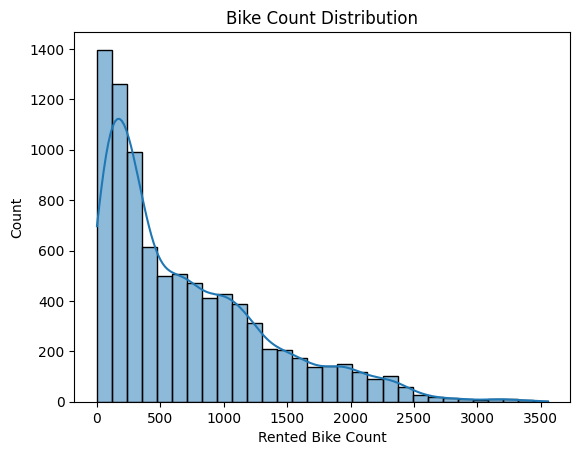


Top Correlations with Rented Bike Count:
Rented Bike Count            1.000000
Temperature(°C)              0.538558
Hour                         0.410257
Dew point temperature(°C)    0.379788
Solar Radiation (MJ/m2)      0.261837
Visibility (10m)             0.199280
Wind speed (m/s)             0.121108
Rainfall(mm)                -0.123074
Snowfall (cm)               -0.141804
Humidity(%)                 -0.199780
Name: Rented Bike Count, dtype: float64


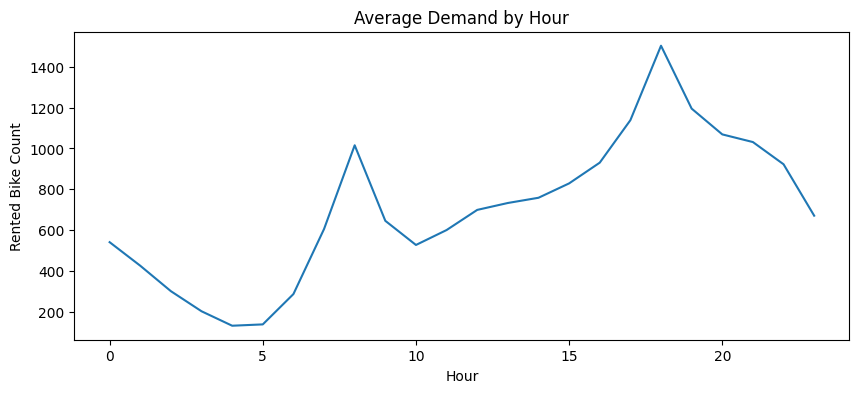

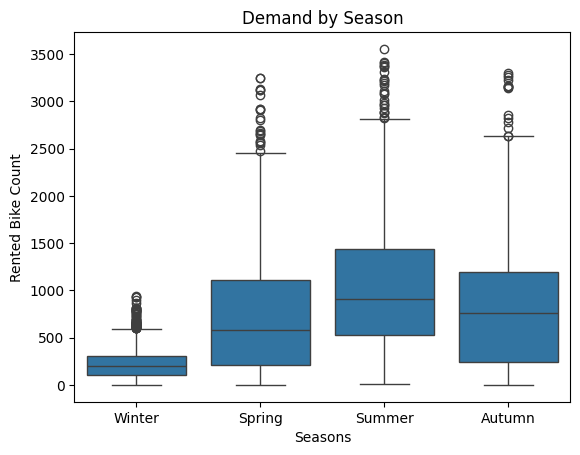

Epoch 1, Loss: 905204.2483
Epoch 2, Loss: 889458.0454
Epoch 3, Loss: 878338.2285
Epoch 4, Loss: 868144.1324
Epoch 5, Loss: 858381.0090
Epoch 6, Loss: 849010.3773
Epoch 7, Loss: 839434.2617
Epoch 8, Loss: 830444.4984
Epoch 9, Loss: 821259.9655
Epoch 10, Loss: 812637.3453
Epoch 11, Loss: 804170.5244
Epoch 12, Loss: 795421.7085
Epoch 13, Loss: 786863.7994
Epoch 14, Loss: 778989.1792
Epoch 15, Loss: 770474.7366
Epoch 16, Loss: 762620.1157
Epoch 17, Loss: 754305.5675
Epoch 18, Loss: 746098.7903
Epoch 19, Loss: 738579.1406
Epoch 20, Loss: 730950.2733
Epoch 21, Loss: 723212.5233
Epoch 22, Loss: 715794.0425
Epoch 23, Loss: 708195.4255
Epoch 24, Loss: 700567.3364
Epoch 25, Loss: 693881.9689
Epoch 26, Loss: 686892.2121
Epoch 27, Loss: 679576.6052
Epoch 28, Loss: 672717.2815
Epoch 29, Loss: 665841.4118
Epoch 30, Loss: 658182.6263
Epoch 31, Loss: 651853.9445
Epoch 32, Loss: 644933.4141
Epoch 33, Loss: 638561.2968
Epoch 34, Loss: 632039.4937
Epoch 35, Loss: 624715.3022
Epoch 36, Loss: 618799.6265
E

In [5]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ============= 1. Load Data ==================
df = pd.read_csv('SeoulBikeData.csv', encoding= 'latin1')
print("CSV Loaded Successfully!")
target_col = 'Rented Bike Count'

# ============= 2. Basic EDA (No new features) ==================
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())
print("\nSummary Statistics:\n", df.describe())

def outlier_count(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    return len(outliers)
for col in ['Rented Bike Count','Wind speed (m/s)','Solar Radiation (MJ/m2)','Rainfall(mm)','Snowfall (cm)']:
    print(f"{col} outliers:", outlier_count(col))

sns.histplot(df['Rented Bike Count'], bins=30, kde=True)
plt.title('Bike Count Distribution')
plt.show()

numeric_df = df.select_dtypes(include=['int64','float64'])
corr = numeric_df.corr()
print("\nTop Correlations with Rented Bike Count:")
print(corr['Rented Bike Count'].sort_values(ascending=False))

plt.figure(figsize=(10,4))
sns.lineplot(
    data=df.groupby('Hour')['Rented Bike Count'].mean().reset_index(),
    x='Hour', y='Rented Bike Count'
)
plt.title('Average Demand by Hour')
plt.show()

if 'Seasons' in df.columns:
    sns.boxplot(x='Seasons', y='Rented Bike Count', data=df)
    plt.title('Demand by Season')
    plt.show()

# ============= 3. Select Original Features Only ==================
# Example set – replace with only original columns in your CSV
original_features = [
    'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day'
]

# Handle non-numeric columns
df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
if 'Seasons' in df.columns:
    df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

# Fill missing values if any
df = df.fillna(0)

X = df[[col for col in original_features if col in df.columns]].values.astype(np.float32)
y = df[target_col].values.astype(np.float32)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape((X_scaled.shape[0], 1, X_scaled.shape[1]))

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train_torch = torch.from_numpy(X_train)
y_train_torch = torch.from_numpy(y_train).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test)
y_test_torch = torch.from_numpy(y_test).unsqueeze(1)
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# ============= 4. LSTM-GRU Hybrid Model ==================
class LSTMGRUHybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden=64, gru_hidden=32):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden, batch_first=True)
        self.gru = nn.GRU(lstm_hidden, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(gru_hidden, 1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        gru_out, _ = self.gru(lstm_out)
        out = self.dropout(gru_out[:,-1,:])
        out = self.fc(out)
        return out

input_dim = X_train.shape[2]
model = LSTMGRUHybrid(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
epochs = 50
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {np.mean(train_losses):.4f}")

# ============= 5. Evaluation (MSE, RMSE, MAE, MAPE) ==================
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)
mse = np.mean(mse_list)
rmse = np.sqrt(mse)
mae = np.mean(mae_list)
mape = np.mean(np.abs((y_true_all - y_pred_all) / np.clip(y_true_all, 1e-8, None))) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")



Shape: (8760, 14)
Columns: ['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day']
Missing values:
 Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

Summary Statistics:
                                 Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 0

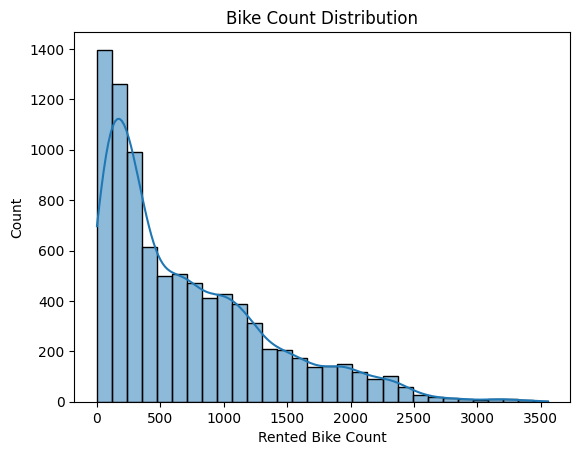


Top Correlations with Rented Bike Count:
Rented Bike Count            1.000000
Temperature(°C)              0.538558
Hour                         0.410257
Dew point temperature(°C)    0.379788
Solar Radiation (MJ/m2)      0.261837
Visibility (10m)             0.199280
Wind speed (m/s)             0.121108
Rainfall(mm)                -0.123074
Snowfall (cm)               -0.141804
Humidity(%)                 -0.199780
Name: Rented Bike Count, dtype: float64


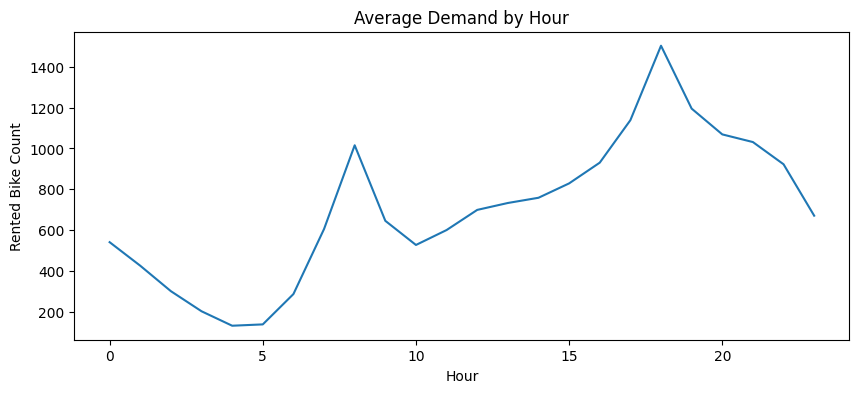

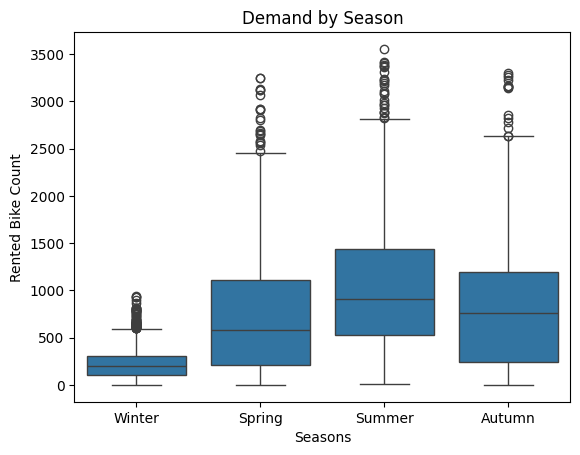

Train shape: (7008, 11), Test shape: (1752, 11)
Train days: 292, Test days: 73
Epoch 1, Loss: 895902.8338
Epoch 2, Loss: 880629.7043
Epoch 3, Loss: 869629.5130
Epoch 4, Loss: 859609.4659
Epoch 5, Loss: 850132.6537
Epoch 6, Loss: 840845.6194
Epoch 7, Loss: 831563.7018
Epoch 8, Loss: 822850.9909
Epoch 9, Loss: 813925.4137
Epoch 10, Loss: 805603.8968
Epoch 11, Loss: 797242.4323
Epoch 12, Loss: 788742.3190
Epoch 13, Loss: 780639.6269
Epoch 14, Loss: 772826.7383
Epoch 15, Loss: 764617.5217
Epoch 16, Loss: 757136.0544
Epoch 17, Loss: 748907.3215
Epoch 18, Loss: 741442.2696
Epoch 19, Loss: 734009.5957
Epoch 20, Loss: 725981.6772
Epoch 21, Loss: 718936.8816
Epoch 22, Loss: 712258.2359
Epoch 23, Loss: 705066.0746
Epoch 24, Loss: 697502.7490
Epoch 25, Loss: 690594.7933
Epoch 26, Loss: 683684.6498
Epoch 27, Loss: 676631.1834
Epoch 28, Loss: 669639.1506
Epoch 29, Loss: 663121.1988
Epoch 30, Loss: 655919.7168
Epoch 31, Loss: 649717.8908
Epoch 32, Loss: 642770.8208
Epoch 33, Loss: 636065.9056
Epoch 

In [7]:
# ======================= 1. Load Libraries ========================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# ======================= 2. Load Data =============================
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)
target_col = 'Rented Bike Count'

# ======================= 3. Basic EDA =============================
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())
print("\nSummary Statistics:\n", df.describe())

def outlier_count(col):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5*IQR) | (df[col] > Q3 + 1.5*IQR)]
    return len(outliers)
for col in ['Rented Bike Count','Wind speed (m/s)','Solar Radiation (MJ/m2)','Rainfall(mm)','Snowfall (cm)']:
    print(f"{col} outliers:", outlier_count(col))

sns.histplot(df['Rented Bike Count'], bins=30, kde=True)
plt.title('Bike Count Distribution')
plt.show()

numeric_df = df.select_dtypes(include=['int64','float64'])
corr = numeric_df.corr()
print("\nTop Correlations with Rented Bike Count:")
print(corr['Rented Bike Count'].sort_values(ascending=False))

plt.figure(figsize=(10,4))
sns.lineplot(
    data=df.groupby('Hour')['Rented Bike Count'].mean().reset_index(),
    x='Hour', y='Rented Bike Count'
)
plt.title('Average Demand by Hour')
plt.show()

if 'Seasons' in df.columns:
    sns.boxplot(x='Seasons', y='Rented Bike Count', data=df)
    plt.title('Demand by Season')
    plt.show()

# ======================= 4. Prepare Features ======================
original_features = [
    'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day'
]

df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
if 'Seasons' in df.columns:
    df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
df = df.fillna(0)

# ======================= 5. Chronological 80/20 Split =============
unique_dates = df['Date'].dt.date.unique()
n_train_days = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:n_train_days]
test_dates = unique_dates[n_train_days:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[[col for col in original_features if col in train_df.columns]].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[[col for col in original_features if col in test_df.columns]].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test).unsqueeze(1)
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train days: {len(train_dates)}, Test days: {len(test_dates)}")

# ======================= 6. LSTM-GRU Hybrid Model =================
class LSTMGRUHybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden=64, gru_hidden=32):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden, batch_first=True)
        self.gru = nn.GRU(lstm_hidden, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(gru_hidden, 1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        gru_out, _ = self.gru(lstm_out)
        out = self.dropout(gru_out[:,-1,:])
        out = self.fc(out)
        return out

input_dim = X_train.shape[1] if len(X_train.shape)==2 else X_train.shape[2]
model = LSTMGRUHybrid(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()
epochs = 50
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {np.mean(train_losses):.4f}")

# ======================= 7. Model Evaluation =======================
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)
mse = np.mean(mse_list)
rmse = np.sqrt(mse)
mae = np.mean(mae_list)
mape = np.mean(np.abs((y_true_all - y_pred_all) / np.clip(y_true_all, 1e-8, None))) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")


In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Load and preprocess data
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)
target_col = 'Rented Bike Count'

# EDA sections can be included as above, omitted here for brevity

original_features = [
    'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day'
]
df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
if 'Seasons' in df.columns:
    df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
df = df.fillna(0)

# Chronological split by day (80/20)
unique_dates = df['Date'].dt.date.unique()
n_train_days = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:n_train_days]
test_dates = unique_dates[n_train_days:]
train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[[col for col in original_features if col in train_df.columns]].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[[col for col in original_features if col in test_df.columns]].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# 2. Normalize input and target (StandardScaler) and reshape for PyTorch
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# 5. Adjusted Model: larger hidden sizes, lower LR
class LSTMGRUHybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden=128, gru_hidden=64):  # Larger layers
        super().__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden, batch_first=True)
        self.gru = nn.GRU(lstm_hidden, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.2)
        self.fc = nn.Linear(gru_hidden, 1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        gru_out, _ = self.gru(lstm_out)
        out = self.dropout(gru_out[:,-1,:])
        out = self.fc(out)
        return out

input_dim = X_train.shape[1] if len(X_train.shape)==2 else X_train.shape[2]
model = LSTMGRUHybrid(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)  # Smaller LR
criterion = nn.MSELoss()
epochs = 50
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}, Loss: {np.mean(train_losses):.4f}")

# 1. MAPE/SMAPE (filter zeros for MAPE, add SMAPE)
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all_scaled = np.concatenate(y_true_all, axis=0)
y_pred_all_scaled = np.concatenate(y_pred_all, axis=0)
# Inverse transform target
y_true_all = scaler_y.inverse_transform(y_true_all_scaled.reshape(-1,1)).flatten()
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1,1)).flatten()
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))

safe_idx = y_true_all > 10  # Filter very small denominators for MAPE
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100

# SMAPE implementation
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all)+1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Epoch 1, Loss: 0.5553
Epoch 2, Loss: 0.3708
Epoch 3, Loss: 0.3319
Epoch 4, Loss: 0.3063
Epoch 5, Loss: 0.2890
Epoch 6, Loss: 0.2784
Epoch 7, Loss: 0.2699
Epoch 8, Loss: 0.2664
Epoch 9, Loss: 0.2612
Epoch 10, Loss: 0.2576
Epoch 11, Loss: 0.2546
Epoch 12, Loss: 0.2528
Epoch 13, Loss: 0.2499
Epoch 14, Loss: 0.2471
Epoch 15, Loss: 0.2461
Epoch 16, Loss: 0.2454
Epoch 17, Loss: 0.2419
Epoch 18, Loss: 0.2415
Epoch 19, Loss: 0.2398
Epoch 20, Loss: 0.2374
Epoch 21, Loss: 0.2350
Epoch 22, Loss: 0.2363
Epoch 23, Loss: 0.2340
Epoch 24, Loss: 0.2326
Epoch 25, Loss: 0.2332
Epoch 26, Loss: 0.2294
Epoch 27, Loss: 0.2297
Epoch 28, Loss: 0.2270
Epoch 29, Loss: 0.2285
Epoch 30, Loss: 0.2245
Epoch 31, Loss: 0.2259
Epoch 32, Loss: 0.2258
Epoch 33, Loss: 0.2204
Epoch 34, Loss: 0.2219
Epoch 35, Loss: 0.2185
Epoch 36, Loss: 0.2199
Epoch 37, Loss: 0.2207
Epoch 38, Loss: 0.2148
Epoch 39, Loss: 0.2169
Epoch 40, Loss: 0.2144
Epoch 41, Loss: 0.2143
Epoch 42, Loss: 0.2122
Epoch 43, Loss: 0.2104
Epoch 44, Loss: 0.20

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# ================= 1. Load & Preprocess Data =====================
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)
target_col = 'Rented Bike Count'

# ================= 2. EDA (Optional) =============================
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print("Missing values:\n", df.isnull().sum())
print("\nSummary Statistics:\n", df.describe())

numeric_df = df.select_dtypes(include=['int64','float64'])
corr = numeric_df.corr()
print("\nTop Correlations with Rented Bike Count:")
print(corr['Rented Bike Count'].sort_values(ascending=False))

original_features = [
    'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day'
]
df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
if 'Seasons' in df.columns:
    df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
df = df.fillna(0)

# =============== 3. Chronological Train/Val/Test Split ==============
unique_dates = df['Date'].dt.date.unique()
n_train_days = int(len(unique_dates) * 0.7)
n_val_days = int(len(unique_dates) * 0.1)
n_test_days = len(unique_dates) - n_train_days - n_val_days
train_dates = unique_dates[:n_train_days]
val_dates = unique_dates[n_train_days:n_train_days + n_val_days]
test_dates = unique_dates[n_train_days + n_val_days:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
val_df = df[df['Date'].dt.date.isin(val_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[[col for col in original_features if col in train_df.columns]].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_val = val_df[[col for col in original_features if col in val_df.columns]].values.astype(np.float32)
y_val = val_df[target_col].values.astype(np.float32)
X_test = test_df[[col for col in original_features if col in test_df.columns]].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# =============== 4. Scaling ==============
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

# PyTorch expects (samples, sequence_len, features) shape
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_scaled)
y_val_torch = torch.from_numpy(y_val_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train days: {len(train_dates)}, Validation days: {len(val_dates)}, Test days: {len(test_dates)}")

# =============== 5. Deep LSTM-GRU Model Definition ==============
class DeepLSTMGRUHybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=64, gru_hidden=64):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.gru = nn.GRU(lstm_hidden2, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(gru_hidden, 1)
    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.gru(out)
        out = self.dropout(out[:,-1,:])
        out = self.fc(out)
        return out

input_dim = X_train.shape[1] if len(X_train.shape)==2 else X_train.shape[2]
model = DeepLSTMGRUHybrid(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# =============== 6. Training with Early Stopping ==============
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()
epochs = 100
patience, patience_counter = 8, 0
best_val_loss = float('inf')

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    # Validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss = criterion(preds, yb)
            val_losses.append(val_loss.item())
    avg_val_loss = np.mean(val_losses)
    print(f"Epoch {epoch+1}: Train Loss {np.mean(train_losses):.4f}, Val Loss {avg_val_loss:.4f}")

    # Early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping: stopping training.")
            break

# Load best model after early stopping
model.load_state_dict(torch.load('best_model.pt'))

# =============== 7. Model Evaluation on Test Data ==============
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all_scaled = np.concatenate(y_true_all, axis=0)
y_pred_all_scaled = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all_scaled.reshape(-1,1)).flatten()
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1,1)).flatten()
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all)+1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Shape: (8760, 14)
Columns: ['Date', 'Rented Bike Count', 'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)', 'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 'Rainfall(mm)', 'Snowfall (cm)', 'Seasons', 'Holiday', 'Functioning Day']
Missing values:
 Date                         0
Rented Bike Count            0
Hour                         0
Temperature(°C)              0
Humidity(%)                  0
Wind speed (m/s)             0
Visibility (10m)             0
Dew point temperature(°C)    0
Solar Radiation (MJ/m2)      0
Rainfall(mm)                 0
Snowfall (cm)                0
Seasons                      0
Holiday                      0
Functioning Day              0
dtype: int64

Summary Statistics:
                                 Date  Rented Bike Count         Hour  \
count                           8760        8760.000000  8760.000000   
mean   2018-05-31 23:59:59.999999744         704.602055    11.500000   
min              2017-12-01 0

added with the new features

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# =============== 1. Load & Feature Engineering =======================
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

# =============== 2. Feature List =======================
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour'
]
# Add season dummies if present
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# =============== 3. Chronological Train/Val/Test Split ==============
unique_dates = df['Date'].dt.date.unique()
n_train_days = int(len(unique_dates) * 0.7)
n_val_days = int(len(unique_dates) * 0.1)
train_dates = unique_dates[:n_train_days]
val_dates = unique_dates[n_train_days:n_train_days + n_val_days]
test_dates = unique_dates[n_train_days + n_val_days:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
val_df = df[df['Date'].dt.date.isin(val_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_val = val_df[feature_cols].values.astype(np.float32)
y_val = val_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# =============== 4. Scaling Data ======================
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_val_scaled = scaler_y.transform(y_val.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_val_scaled = X_val_scaled.reshape((X_val_scaled.shape[0], 1, X_val_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_val_torch = torch.from_numpy(X_val_scaled)
y_val_torch = torch.from_numpy(y_val_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
val_dataset = TensorDataset(X_val_torch, y_val_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train days: {len(train_dates)}, Validation days: {len(val_dates)}, Test days: {len(test_dates)}")

# =============== 5. Deep LSTM-GRU Hybrid Model ==============
class DeepLSTMGRUHybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=64, gru_hidden=64):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.gru = nn.GRU(lstm_hidden2, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(gru_hidden, 1)
    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.gru(out)
        out = self.dropout(out[:,-1,:])
        out = self.fc(out)
        return out

input_dim = X_train.shape[1]
model = DeepLSTMGRUHybrid(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()
epochs = 100
patience, patience_counter = 8, 0
best_val_loss = float('inf')

# =============== 6. Training with Early Stopping ==============
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            val_loss = criterion(preds, yb)
            val_losses.append(val_loss.item())
    avg_val_loss = np.mean(val_losses)
    print(f"Epoch {epoch+1}: Train Loss {np.mean(train_losses):.4f}, Val Loss {avg_val_loss:.4f}")
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        patience_counter = 0
        torch.save(model.state_dict(), 'best_model.pt')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping: stopping training.")
            break

model.load_state_dict(torch.load('best_model.pt'))

# =============== 7. Model Evaluation =====================
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all_scaled = np.concatenate(y_true_all, axis=0)
y_pred_all_scaled = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all_scaled.reshape(-1,1)).flatten()
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1,1)).flatten()
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all)+1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Train days: 255, Validation days: 36, Test days: 74
Epoch 1: Train Loss 0.5293, Val Loss 0.5501
Epoch 2: Train Loss 0.2481, Val Loss 0.5117
Epoch 3: Train Loss 0.2046, Val Loss 0.5304
Epoch 4: Train Loss 0.1779, Val Loss 0.5572
Epoch 5: Train Loss 0.1678, Val Loss 0.5674
Epoch 6: Train Loss 0.1630, Val Loss 0.5918
Epoch 7: Train Loss 0.1513, Val Loss 0.5772
Epoch 8: Train Loss 0.1503, Val Loss 0.5823
Epoch 9: Train Loss 0.1444, Val Loss 0.5007
Epoch 10: Train Loss 0.1449, Val Loss 0.4855
Epoch 11: Train Loss 0.1430, Val Loss 0.5809
Epoch 12: Train Loss 0.1386, Val Loss 0.5072
Epoch 13: Train Loss 0.1383, Val Loss 0.6093
Epoch 14: Train Loss 0.1333, Val Loss 0.5195
Epoch 15: Train Loss 0.1321, Val Loss 0.5530
Epoch 16: Train Loss 0.1326, Val Loss 0.5499
Epoch 17: Train Loss 0.1289, Val Loss 0.5613
Epoch 18: Train Loss 0.1271, Val Loss 0.6477
Early stopping: stopping training.
Test MSE: 134764.4375
Test RMSE: 367.1028
Test MAE: 248.0447
Test MAPE: 56.73% (filtered zeros)
Test SMAPE: 63.0

train test

In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# =============== 1. Load & Feature Engineering =======================
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

# =============== 2. Feature List =======================
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour'
]
# Add season dummies if present
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# =============== 3. Chronological Train/Test Split =================
unique_dates = df['Date'].dt.date.unique()
n_train_days = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:n_train_days]
test_dates = unique_dates[n_train_days:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# =============== 4. Scaling Data ======================
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train days: {len(train_dates)}, Test days: {len(test_dates)}")

# =============== 5. Deep LSTM-GRU Hybrid Model ==============
class DeepLSTMGRUHybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=64, gru_hidden=64):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.gru = nn.GRU(lstm_hidden2, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(gru_hidden, 1)
    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.gru(out)
        out = self.dropout(out[:,-1,:])
        out = self.fc(out)
        return out

input_dim = X_train.shape[1]
model = DeepLSTMGRUHybrid(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# =============== 6. Training =====================
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()
epochs = 70  # Use validation for early stopping if you want, but here train for a fixed number

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}: Train Loss {np.mean(train_losses):.4f}")

# =============== 7. Model Evaluation =====================
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all_scaled = np.concatenate(y_true_all, axis=0)
y_pred_all_scaled = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all_scaled.reshape(-1,1)).flatten()
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1,1)).flatten()
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all)+1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Train shape: (7008, 23), Test shape: (1752, 23)
Train days: 292, Test days: 73
Epoch 1: Train Loss 0.4853
Epoch 2: Train Loss 0.2422
Epoch 3: Train Loss 0.1981
Epoch 4: Train Loss 0.1777
Epoch 5: Train Loss 0.1713
Epoch 6: Train Loss 0.1648
Epoch 7: Train Loss 0.1605
Epoch 8: Train Loss 0.1569
Epoch 9: Train Loss 0.1565
Epoch 10: Train Loss 0.1498
Epoch 11: Train Loss 0.1495
Epoch 12: Train Loss 0.1446
Epoch 13: Train Loss 0.1409
Epoch 14: Train Loss 0.1391
Epoch 15: Train Loss 0.1371
Epoch 16: Train Loss 0.1297
Epoch 17: Train Loss 0.1290
Epoch 18: Train Loss 0.1250
Epoch 19: Train Loss 0.1255
Epoch 20: Train Loss 0.1216
Epoch 21: Train Loss 0.1193
Epoch 22: Train Loss 0.1178
Epoch 23: Train Loss 0.1159
Epoch 24: Train Loss 0.1159
Epoch 25: Train Loss 0.1148
Epoch 26: Train Loss 0.1109
Epoch 27: Train Loss 0.1110
Epoch 28: Train Loss 0.1098
Epoch 29: Train Loss 0.1101
Epoch 30: Train Loss 0.1082
Epoch 31: Train Loss 0.1070
Epoch 32: Train Loss 0.1072
Epoch 33: Train Loss 0.1057
Epoch 

Adding more layers

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# =============== 1. Load & Feature Engineering =======================
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

# =============== 2. Feature List =======================
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour'
]
# Add season dummies if present
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# =============== 3. Chronological Train/Test Split =================
unique_dates = df['Date'].dt.date.unique()
n_train_days = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:n_train_days]
test_dates = unique_dates[n_train_days:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# =============== 4. Scaling Data ======================
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train days: {len(train_dates)}, Test days: {len(test_dates)}")

# =============== 5. Deep LSTM-GRU Hybrid Model ==============
import torch
import torch.nn as nn

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=128, lstm_hidden3=64, gru_hidden=64, attn_dim=64):
        super().__init__()
        # Deep LSTM stack (now 3 layers)
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True)
        # GRU layer
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        # Attention Layer: Self-attention after GRU output (sequence-to-vector)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        # LSTM Stack
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        # GRU
        out, _ = self.gru(out)  # out: (batch, seq_len, gru_hidden)
        # Attention mechanism (Simple self-attention over time axis)
        attn_weights = torch.tanh(self.attn(out))    # (batch, seq_len, attn_dim)
        attn_weights = self.attn_score(attn_weights) # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # normalize over sequence
        attended = (out * attn_weights).sum(dim=1)         # weighted sum over time axis (self-attention)
        # Dropout & Dense Output
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

# When instantiating:
input_dim = X_train.shape[1]
model = DeepLSTMGRUAttention(input_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# =============== 6. Training =====================
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()
epochs = 70  # Use validation for early stopping if you want, but here train for a fixed number

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}: Train Loss {np.mean(train_losses):.4f}")

# =============== 7. Model Evaluation =====================
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all_scaled = np.concatenate(y_true_all, axis=0)
y_pred_all_scaled = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all_scaled.reshape(-1,1)).flatten()
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1,1)).flatten()
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all)+1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Train shape: (7008, 23), Test shape: (1752, 23)
Train days: 292, Test days: 73
Epoch 1: Train Loss 0.4964
Epoch 2: Train Loss 0.2323
Epoch 3: Train Loss 0.1906
Epoch 4: Train Loss 0.1737
Epoch 5: Train Loss 0.1655
Epoch 6: Train Loss 0.1653
Epoch 7: Train Loss 0.1581
Epoch 8: Train Loss 0.1532
Epoch 9: Train Loss 0.1526
Epoch 10: Train Loss 0.1500
Epoch 11: Train Loss 0.1465
Epoch 12: Train Loss 0.1423
Epoch 13: Train Loss 0.1393
Epoch 14: Train Loss 0.1349
Epoch 15: Train Loss 0.1334
Epoch 16: Train Loss 0.1274
Epoch 17: Train Loss 0.1266
Epoch 18: Train Loss 0.1237
Epoch 19: Train Loss 0.1181
Epoch 20: Train Loss 0.1153
Epoch 21: Train Loss 0.1166
Epoch 22: Train Loss 0.1148
Epoch 23: Train Loss 0.1146
Epoch 24: Train Loss 0.1139
Epoch 25: Train Loss 0.1128
Epoch 26: Train Loss 0.1111
Epoch 27: Train Loss 0.1114
Epoch 28: Train Loss 0.1110
Epoch 29: Train Loss 0.1095
Epoch 30: Train Loss 0.1076
Epoch 31: Train Loss 0.1065
Epoch 32: Train Loss 0.1042
Epoch 33: Train Loss 0.1042
Epoch 

added another LSTM

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# =============== 1. Load & Feature Engineering =======================
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

# =============== 2. Feature List =======================
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour'
]
# Add season dummies if present
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# =============== 3. Chronological Train/Test Split =================
unique_dates = df['Date'].dt.date.unique()
n_train_days = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:n_train_days]
test_dates = unique_dates[n_train_days:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# =============== 4. Scaling Data ======================
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train days: {len(train_dates)}, Test days: {len(test_dates)}")

# =============== 5. Deep LSTM-GRU Hybrid Model ==============
import torch
import torch.nn as nn

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=128, lstm_hidden3=64, gru_hidden=64, attn_dim=64):
        super().__init__()
        # Deep LSTM stack (now 3 layers)
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True)
        self.lstm4 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True)
        # GRU layer
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        # Attention Layer: Self-attention after GRU output (sequence-to-vector)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        # LSTM Stack
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        # GRU
        out, _ = self.gru(out)  # out: (batch, seq_len, gru_hidden)
        # Attention mechanism (Simple self-attention over time axis)
        attn_weights = torch.tanh(self.attn(out))    # (batch, seq_len, attn_dim)
        attn_weights = self.attn_score(attn_weights) # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # normalize over sequence
        attended = (out * attn_weights).sum(dim=1)         # weighted sum over time axis (self-attention)
        # Dropout & Dense Output
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

# When instantiating:
input_dim = X_train.shape[1]
model = DeepLSTMGRUAttention(input_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# =============== 6. Training =====================
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.MSELoss()
epochs = 70  # Use validation for early stopping if you want, but here train for a fixed number

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}: Train Loss {np.mean(train_losses):.4f}")

# =============== 7. Model Evaluation =====================
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all_scaled = np.concatenate(y_true_all, axis=0)
y_pred_all_scaled = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all_scaled.reshape(-1,1)).flatten()
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1,1)).flatten()
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all)+1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Train shape: (7008, 23), Test shape: (1752, 23)
Train days: 292, Test days: 73
Epoch 1: Train Loss 0.4909
Epoch 2: Train Loss 0.2337
Epoch 3: Train Loss 0.1944
Epoch 4: Train Loss 0.1767
Epoch 5: Train Loss 0.1662
Epoch 6: Train Loss 0.1637
Epoch 7: Train Loss 0.1581
Epoch 8: Train Loss 0.1564
Epoch 9: Train Loss 0.1534
Epoch 10: Train Loss 0.1500
Epoch 11: Train Loss 0.1462
Epoch 12: Train Loss 0.1449
Epoch 13: Train Loss 0.1403
Epoch 14: Train Loss 0.1361
Epoch 15: Train Loss 0.1302
Epoch 16: Train Loss 0.1281
Epoch 17: Train Loss 0.1225
Epoch 18: Train Loss 0.1196
Epoch 19: Train Loss 0.1210
Epoch 20: Train Loss 0.1182
Epoch 21: Train Loss 0.1143
Epoch 22: Train Loss 0.1193
Epoch 23: Train Loss 0.1143
Epoch 24: Train Loss 0.1138
Epoch 25: Train Loss 0.1119
Epoch 26: Train Loss 0.1127
Epoch 27: Train Loss 0.1098
Epoch 28: Train Loss 0.1101
Epoch 29: Train Loss 0.1076
Epoch 30: Train Loss 0.1049
Epoch 31: Train Loss 0.1069
Epoch 32: Train Loss 0.1027
Epoch 33: Train Loss 0.1030
Epoch 

changing LR

In [16]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# =============== 1. Load & Feature Engineering =======================
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

# =============== 2. Feature List =======================
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour'
]
# Add season dummies if present
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# =============== 3. Chronological Train/Test Split =================
unique_dates = df['Date'].dt.date.unique()
n_train_days = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:n_train_days]
test_dates = unique_dates[n_train_days:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# =============== 4. Scaling Data ======================
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train days: {len(train_dates)}, Test days: {len(test_dates)}")

# =============== 5. Deep LSTM-GRU Hybrid Model ==============
import torch
import torch.nn as nn

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=128, lstm_hidden3=64, gru_hidden=64, attn_dim=64):
        super().__init__()
        # Deep LSTM stack (now 3 layers)
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True)
        # GRU layer
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        # Attention Layer: Self-attention after GRU output (sequence-to-vector)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        # LSTM Stack
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        # GRU
        out, _ = self.gru(out)  # out: (batch, seq_len, gru_hidden)
        # Attention mechanism (Simple self-attention over time axis)
        attn_weights = torch.tanh(self.attn(out))    # (batch, seq_len, attn_dim)
        attn_weights = self.attn_score(attn_weights) # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # normalize over sequence
        attended = (out * attn_weights).sum(dim=1)         # weighted sum over time axis (self-attention)
        # Dropout & Dense Output
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

# When instantiating:
input_dim = X_train.shape[1]
model = DeepLSTMGRUAttention(input_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# =============== 6. Training =====================
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.MSELoss()
epochs = 70  # Use validation for early stopping if you want, but here train for a fixed number

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}: Train Loss {np.mean(train_losses):.4f}")

# =============== 7. Model Evaluation =====================
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all_scaled = np.concatenate(y_true_all, axis=0)
y_pred_all_scaled = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all_scaled.reshape(-1,1)).flatten()
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1,1)).flatten()
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all)+1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Train shape: (7008, 23), Test shape: (1752, 23)
Train days: 292, Test days: 73
Epoch 1: Train Loss 1.0000
Epoch 2: Train Loss 0.9936
Epoch 3: Train Loss 0.9607
Epoch 4: Train Loss 0.8211
Epoch 5: Train Loss 0.5727
Epoch 6: Train Loss 0.4407
Epoch 7: Train Loss 0.3980
Epoch 8: Train Loss 0.3774
Epoch 9: Train Loss 0.3626
Epoch 10: Train Loss 0.3506
Epoch 11: Train Loss 0.3390
Epoch 12: Train Loss 0.3295
Epoch 13: Train Loss 0.3184
Epoch 14: Train Loss 0.3097
Epoch 15: Train Loss 0.3053
Epoch 16: Train Loss 0.2960
Epoch 17: Train Loss 0.2939
Epoch 18: Train Loss 0.2867
Epoch 19: Train Loss 0.2805
Epoch 20: Train Loss 0.2760
Epoch 21: Train Loss 0.2713
Epoch 22: Train Loss 0.2675
Epoch 23: Train Loss 0.2637
Epoch 24: Train Loss 0.2592
Epoch 25: Train Loss 0.2569
Epoch 26: Train Loss 0.2527
Epoch 27: Train Loss 0.2488
Epoch 28: Train Loss 0.2457
Epoch 29: Train Loss 0.2437
Epoch 30: Train Loss 0.2398
Epoch 31: Train Loss 0.2373
Epoch 32: Train Loss 0.2355
Epoch 33: Train Loss 0.2351
Epoch 

In [17]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# =============== 1. Load & Feature Engineering =======================
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

# =============== 2. Feature List =======================
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour'
]
# Add season dummies if present
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# =============== 3. Chronological Train/Test Split =================
unique_dates = df['Date'].dt.date.unique()
n_train_days = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:n_train_days]
test_dates = unique_dates[n_train_days:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# =============== 4. Scaling Data ======================
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train days: {len(train_dates)}, Test days: {len(test_dates)}")

# =============== 5. Deep LSTM-GRU Hybrid Model ==============
import torch
import torch.nn as nn

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=128, lstm_hidden3=64, gru_hidden=64, attn_dim=64):
        super().__init__()
        # Deep LSTM stack (now 3 layers)
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True)
        # GRU layer
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        # Attention Layer: Self-attention after GRU output (sequence-to-vector)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        # LSTM Stack
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        # GRU
        out, _ = self.gru(out)  # out: (batch, seq_len, gru_hidden)
        # Attention mechanism (Simple self-attention over time axis)
        attn_weights = torch.tanh(self.attn(out))    # (batch, seq_len, attn_dim)
        attn_weights = self.attn_score(attn_weights) # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # normalize over sequence
        attended = (out * attn_weights).sum(dim=1)         # weighted sum over time axis (self-attention)
        # Dropout & Dense Output
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

# When instantiating:
input_dim = X_train.shape[1]
model = DeepLSTMGRUAttention(input_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# =============== 6. Training =====================
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 70  # Use validation for early stopping if you want, but here train for a fixed number

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}: Train Loss {np.mean(train_losses):.4f}")

# =============== 7. Model Evaluation =====================
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all_scaled = np.concatenate(y_true_all, axis=0)
y_pred_all_scaled = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all_scaled.reshape(-1,1)).flatten()
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1,1)).flatten()
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all)+1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Train shape: (7008, 23), Test shape: (1752, 23)
Train days: 292, Test days: 73
Epoch 1: Train Loss 0.7111
Epoch 2: Train Loss 0.3109
Epoch 3: Train Loss 0.2547
Epoch 4: Train Loss 0.2248
Epoch 5: Train Loss 0.2064
Epoch 6: Train Loss 0.1925
Epoch 7: Train Loss 0.1804
Epoch 8: Train Loss 0.1749
Epoch 9: Train Loss 0.1690
Epoch 10: Train Loss 0.1667
Epoch 11: Train Loss 0.1642
Epoch 12: Train Loss 0.1622
Epoch 13: Train Loss 0.1584
Epoch 14: Train Loss 0.1580
Epoch 15: Train Loss 0.1569
Epoch 16: Train Loss 0.1536
Epoch 17: Train Loss 0.1555
Epoch 18: Train Loss 0.1523
Epoch 19: Train Loss 0.1518
Epoch 20: Train Loss 0.1479
Epoch 21: Train Loss 0.1473
Epoch 22: Train Loss 0.1446
Epoch 23: Train Loss 0.1442
Epoch 24: Train Loss 0.1445
Epoch 25: Train Loss 0.1443
Epoch 26: Train Loss 0.1441
Epoch 27: Train Loss 0.1391
Epoch 28: Train Loss 0.1372
Epoch 29: Train Loss 0.1381
Epoch 30: Train Loss 0.1372
Epoch 31: Train Loss 0.1363
Epoch 32: Train Loss 0.1340
Epoch 33: Train Loss 0.1331
Epoch 

In [18]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# =============== 1. Load & Feature Engineering =======================
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

# =============== 2. Feature List =======================
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour'
]
# Add season dummies if present
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# =============== 3. Chronological Train/Test Split =================
unique_dates = df['Date'].dt.date.unique()
n_train_days = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:n_train_days]
test_dates = unique_dates[n_train_days:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# =============== 4. Scaling Data ======================
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train days: {len(train_dates)}, Test days: {len(test_dates)}")

# =============== 5. Deep LSTM-GRU Hybrid Model ==============
import torch
import torch.nn as nn

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=128, lstm_hidden3=64, gru_hidden=64, attn_dim=64):
        super().__init__()
        # Deep LSTM stack (now 3 layers)
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True)
        # GRU layer
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        # Attention Layer: Self-attention after GRU output (sequence-to-vector)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        # LSTM Stack
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        # GRU
        out, _ = self.gru(out)  # out: (batch, seq_len, gru_hidden)
        # Attention mechanism (Simple self-attention over time axis)
        attn_weights = torch.tanh(self.attn(out))    # (batch, seq_len, attn_dim)
        attn_weights = self.attn_score(attn_weights) # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # normalize over sequence
        attended = (out * attn_weights).sum(dim=1)         # weighted sum over time axis (self-attention)
        # Dropout & Dense Output
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

# When instantiating:
input_dim = X_train.shape[1]
model = DeepLSTMGRUAttention(input_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# =============== 6. Training =====================
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
epochs = 70  # Use validation for early stopping if you want, but here train for a fixed number

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}: Train Loss {np.mean(train_losses):.4f}")

# =============== 7. Model Evaluation =====================
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all_scaled = np.concatenate(y_true_all, axis=0)
y_pred_all_scaled = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all_scaled.reshape(-1,1)).flatten()
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1,1)).flatten()
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all)+1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Train shape: (7008, 23), Test shape: (1752, 23)
Train days: 292, Test days: 73
Epoch 1: Train Loss 0.9051
Epoch 2: Train Loss 0.3959
Epoch 3: Train Loss 0.3230
Epoch 4: Train Loss 0.2872
Epoch 5: Train Loss 0.2611
Epoch 6: Train Loss 0.2430
Epoch 7: Train Loss 0.2291
Epoch 8: Train Loss 0.2186
Epoch 9: Train Loss 0.2066
Epoch 10: Train Loss 0.1990
Epoch 11: Train Loss 0.1916
Epoch 12: Train Loss 0.1821
Epoch 13: Train Loss 0.1785
Epoch 14: Train Loss 0.1737
Epoch 15: Train Loss 0.1683
Epoch 16: Train Loss 0.1691
Epoch 17: Train Loss 0.1662
Epoch 18: Train Loss 0.1648
Epoch 19: Train Loss 0.1637
Epoch 20: Train Loss 0.1616
Epoch 21: Train Loss 0.1595
Epoch 22: Train Loss 0.1596
Epoch 23: Train Loss 0.1586
Epoch 24: Train Loss 0.1571
Epoch 25: Train Loss 0.1547
Epoch 26: Train Loss 0.1544
Epoch 27: Train Loss 0.1545
Epoch 28: Train Loss 0.1557
Epoch 29: Train Loss 0.1515
Epoch 30: Train Loss 0.1497
Epoch 31: Train Loss 0.1508
Epoch 32: Train Loss 0.1514
Epoch 33: Train Loss 0.1487
Epoch 

In [19]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# =============== 1. Load & Feature Engineering =======================
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

# =============== 2. Feature List =======================
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour'
]
# Add season dummies if present
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# =============== 3. Chronological Train/Test Split =================
unique_dates = df['Date'].dt.date.unique()
n_train_days = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:n_train_days]
test_dates = unique_dates[n_train_days:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# =============== 4. Scaling Data ======================
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train days: {len(train_dates)}, Test days: {len(test_dates)}")

# =============== 5. Deep LSTM-GRU Hybrid Model ==============
import torch
import torch.nn as nn

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=128, lstm_hidden3=64, gru_hidden=64, attn_dim=64):
        super().__init__()
        # Deep LSTM stack (now 3 layers)
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True)
        # GRU layer
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        # Attention Layer: Self-attention after GRU output (sequence-to-vector)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        # LSTM Stack
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        # GRU
        out, _ = self.gru(out)  # out: (batch, seq_len, gru_hidden)
        # Attention mechanism (Simple self-attention over time axis)
        attn_weights = torch.tanh(self.attn(out))    # (batch, seq_len, attn_dim)
        attn_weights = self.attn_score(attn_weights) # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # normalize over sequence
        attended = (out * attn_weights).sum(dim=1)         # weighted sum over time axis (self-attention)
        # Dropout & Dense Output
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

# When instantiating:
input_dim = X_train.shape[1]
model = DeepLSTMGRUAttention(input_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# =============== 6. Training =====================
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
criterion = nn.MSELoss()
epochs = 70  # Use validation for early stopping if you want, but here train for a fixed number

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}: Train Loss {np.mean(train_losses):.4f}")

# =============== 7. Model Evaluation =====================
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all_scaled = np.concatenate(y_true_all, axis=0)
y_pred_all_scaled = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all_scaled.reshape(-1,1)).flatten()
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1,1)).flatten()
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all)+1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Train shape: (7008, 23), Test shape: (1752, 23)
Train days: 292, Test days: 73
Epoch 1: Train Loss 1.0033
Epoch 2: Train Loss 1.0009
Epoch 3: Train Loss 0.9984
Epoch 4: Train Loss 0.9918
Epoch 5: Train Loss 0.9777
Epoch 6: Train Loss 0.9448
Epoch 7: Train Loss 0.8795
Epoch 8: Train Loss 0.7693
Epoch 9: Train Loss 0.6466
Epoch 10: Train Loss 0.5482
Epoch 11: Train Loss 0.4817
Epoch 12: Train Loss 0.4468
Epoch 13: Train Loss 0.4212
Epoch 14: Train Loss 0.4050
Epoch 15: Train Loss 0.3958
Epoch 16: Train Loss 0.3880
Epoch 17: Train Loss 0.3799
Epoch 18: Train Loss 0.3755
Epoch 19: Train Loss 0.3680
Epoch 20: Train Loss 0.3618
Epoch 21: Train Loss 0.3577
Epoch 22: Train Loss 0.3508
Epoch 23: Train Loss 0.3491
Epoch 24: Train Loss 0.3425
Epoch 25: Train Loss 0.3391
Epoch 26: Train Loss 0.3367
Epoch 27: Train Loss 0.3338
Epoch 28: Train Loss 0.3280
Epoch 29: Train Loss 0.3243
Epoch 30: Train Loss 0.3207
Epoch 31: Train Loss 0.3175
Epoch 32: Train Loss 0.3159
Epoch 33: Train Loss 0.3115
Epoch 

In [20]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# =============== 1. Load & Feature Engineering =======================
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

# =============== 2. Feature List =======================
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour'
]
# Add season dummies if present
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# =============== 3. Chronological Train/Test Split =================
unique_dates = df['Date'].dt.date.unique()
n_train_days = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:n_train_days]
test_dates = unique_dates[n_train_days:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# =============== 4. Scaling Data ======================
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train days: {len(train_dates)}, Test days: {len(test_dates)}")

# =============== 5. Deep LSTM-GRU Hybrid Model ==============
import torch
import torch.nn as nn

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=128, lstm_hidden3=64, gru_hidden=64, attn_dim=64):
        super().__init__()
        # Deep LSTM stack (now 3 layers)
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True)
        # GRU layer
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        # Attention Layer: Self-attention after GRU output (sequence-to-vector)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        # LSTM Stack
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        # GRU
        out, _ = self.gru(out)  # out: (batch, seq_len, gru_hidden)
        # Attention mechanism (Simple self-attention over time axis)
        attn_weights = torch.tanh(self.attn(out))    # (batch, seq_len, attn_dim)
        attn_weights = self.attn_score(attn_weights) # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # normalize over sequence
        attended = (out * attn_weights).sum(dim=1)         # weighted sum over time axis (self-attention)
        # Dropout & Dense Output
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

# When instantiating:
input_dim = X_train.shape[1]
model = DeepLSTMGRUAttention(input_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# =============== 6. Training =====================
optimizer = torch.optim.Adam(model.parameters(), lr=2e-6)
criterion = nn.MSELoss()
epochs = 70  # Use validation for early stopping if you want, but here train for a fixed number

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}: Train Loss {np.mean(train_losses):.4f}")

# =============== 7. Model Evaluation =====================
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all_scaled = np.concatenate(y_true_all, axis=0)
y_pred_all_scaled = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all_scaled.reshape(-1,1)).flatten()
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1,1)).flatten()
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all)+1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Train shape: (7008, 23), Test shape: (1752, 23)
Train days: 292, Test days: 73
Epoch 1: Train Loss 1.0005
Epoch 2: Train Loss 1.0002
Epoch 3: Train Loss 1.0002
Epoch 4: Train Loss 1.0001
Epoch 5: Train Loss 0.9998
Epoch 6: Train Loss 0.9988
Epoch 7: Train Loss 0.9988
Epoch 8: Train Loss 0.9982
Epoch 9: Train Loss 0.9981
Epoch 10: Train Loss 0.9971
Epoch 11: Train Loss 0.9969
Epoch 12: Train Loss 0.9969
Epoch 13: Train Loss 0.9955
Epoch 14: Train Loss 0.9954
Epoch 15: Train Loss 0.9953
Epoch 16: Train Loss 0.9939
Epoch 17: Train Loss 0.9924
Epoch 18: Train Loss 0.9913
Epoch 19: Train Loss 0.9900
Epoch 20: Train Loss 0.9881
Epoch 21: Train Loss 0.9868
Epoch 22: Train Loss 0.9848
Epoch 23: Train Loss 0.9825
Epoch 24: Train Loss 0.9801
Epoch 25: Train Loss 0.9777
Epoch 26: Train Loss 0.9743
Epoch 27: Train Loss 0.9708
Epoch 28: Train Loss 0.9678
Epoch 29: Train Loss 0.9629
Epoch 30: Train Loss 0.9587
Epoch 31: Train Loss 0.9535
Epoch 32: Train Loss 0.9482
Epoch 33: Train Loss 0.9430
Epoch 

In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# =============== 1. Load & Feature Engineering =======================
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

# =============== 2. Feature List =======================
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour'
]
# Add season dummies if present
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# =============== 3. Chronological Train/Test Split =================
unique_dates = df['Date'].dt.date.unique()
n_train_days = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:n_train_days]
test_dates = unique_dates[n_train_days:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# =============== 4. Scaling Data ======================
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train days: {len(train_dates)}, Test days: {len(test_dates)}")

# =============== 5. Deep LSTM-GRU Hybrid Model ==============
import torch
import torch.nn as nn

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=128, lstm_hidden3=64, gru_hidden=64, attn_dim=64):
        super().__init__()
        # Deep LSTM stack (now 3 layers)
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True)
        # GRU layer
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        # Attention Layer: Self-attention after GRU output (sequence-to-vector)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        # LSTM Stack
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        # GRU
        out, _ = self.gru(out)  # out: (batch, seq_len, gru_hidden)
        # Attention mechanism (Simple self-attention over time axis)
        attn_weights = torch.tanh(self.attn(out))    # (batch, seq_len, attn_dim)
        attn_weights = self.attn_score(attn_weights) # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # normalize over sequence
        attended = (out * attn_weights).sum(dim=1)         # weighted sum over time axis (self-attention)
        # Dropout & Dense Output
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

# When instantiating:
input_dim = X_train.shape[1]
model = DeepLSTMGRUAttention(input_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# =============== 6. Training =====================
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = nn.MSELoss()
epochs = 70  # Use validation for early stopping if you want, but here train for a fixed number

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}: Train Loss {np.mean(train_losses):.4f}")

# =============== 7. Model Evaluation =====================
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all_scaled = np.concatenate(y_true_all, axis=0)
y_pred_all_scaled = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all_scaled.reshape(-1,1)).flatten()
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1,1)).flatten()
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all)+1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Train shape: (7008, 23), Test shape: (1752, 23)
Train days: 292, Test days: 73
Epoch 1: Train Loss 0.6084
Epoch 2: Train Loss 0.2754
Epoch 3: Train Loss 0.2270
Epoch 4: Train Loss 0.1972
Epoch 5: Train Loss 0.1804
Epoch 6: Train Loss 0.1699
Epoch 7: Train Loss 0.1653
Epoch 8: Train Loss 0.1625
Epoch 9: Train Loss 0.1592
Epoch 10: Train Loss 0.1568
Epoch 11: Train Loss 0.1547
Epoch 12: Train Loss 0.1526
Epoch 13: Train Loss 0.1503
Epoch 14: Train Loss 0.1474
Epoch 15: Train Loss 0.1487
Epoch 16: Train Loss 0.1439
Epoch 17: Train Loss 0.1419
Epoch 18: Train Loss 0.1396
Epoch 19: Train Loss 0.1380
Epoch 20: Train Loss 0.1355
Epoch 21: Train Loss 0.1336
Epoch 22: Train Loss 0.1326
Epoch 23: Train Loss 0.1312
Epoch 24: Train Loss 0.1301
Epoch 25: Train Loss 0.1278
Epoch 26: Train Loss 0.1247
Epoch 27: Train Loss 0.1260
Epoch 28: Train Loss 0.1218
Epoch 29: Train Loss 0.1179
Epoch 30: Train Loss 0.1203
Epoch 31: Train Loss 0.1196
Epoch 32: Train Loss 0.1191
Epoch 33: Train Loss 0.1202
Epoch 

adding rolling window

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# -------------------- 1. Load and Feature Engineering --------------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)

def add_engineered_features(df):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
target_col = 'Rented Bike Count'

# Feature columns (engineered + original)
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# -------------------- 2. Windowed Data Creation --------------------
window_size = 6  # past 24 hours

X_win, y_win, time_win = [], [], []
for i in range(window_size, len(df)):
    X_win.append(df[feature_cols].iloc[i-window_size:i].values)
    y_win.append(df[target_col].iloc[i])
    time_win.append(df['Date'].iloc[i]) # for chronological split

X_win = np.array(X_win, dtype=np.float32)
y_win = np.array(y_win, dtype=np.float32)
time_win = np.array(time_win)

# -------------------- 3. Chronological Train/Test Split --------------------
unique_dates = pd.Series(time_win).dt.date.unique()
n_train_days = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:n_train_days]
test_dates = unique_dates[n_train_days:]

train_idx = [d in train_dates for d in pd.Series(time_win).dt.date]
test_idx = [d in test_dates for d in pd.Series(time_win).dt.date]

X_train = X_win[train_idx]
y_train = y_win[train_idx]
X_test = X_win[test_idx]
y_test = y_win[test_idx]

# -------------------- 4. Scaling --------------------
# Fit scaler only on TRAIN, then apply to test
X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_test_flat = X_test.reshape(-1, X_test.shape[-1])
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_flat_scaled = scaler_X.fit_transform(X_train_flat)
X_test_flat_scaled = scaler_X.transform(X_test_flat)

# Reshape back to (samples, win, features)
X_train_scaled = X_train_flat_scaled.reshape(X_train.shape)
X_test_scaled = X_test_flat_scaled.reshape(X_test.shape)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# -------------------- 5. Deep LSTM-GRU Model with Attention --------------------
class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=128, lstm_hidden3=64, gru_hidden=64, attn_dim=64):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True)
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)
    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)  # out: (batch, seq_len, gru_hidden)
        attn_weights = torch.tanh(self.attn(out))   # (batch, seq_len, attn_dim)
        attn_weights = self.attn_score(attn_weights) # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = (out * attn_weights).sum(dim=1)
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

input_dim = X_train.shape[2]
model = DeepLSTMGRUAttention(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# -------------------- 6. Training --------------------
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 70

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}: Train Loss {np.mean(train_losses):.4f}")

# -------------------- 7. Evaluation --------------------
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all_scaled = np.concatenate(y_true_all, axis=0)
y_pred_all_scaled = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all_scaled.reshape(-1,1)).flatten()
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1,1)).flatten()
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all)+1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Train samples: 7002, Test samples: 1752
Epoch 1: Train Loss 0.5407
Epoch 2: Train Loss 0.2835
Epoch 3: Train Loss 0.2365
Epoch 4: Train Loss 0.2114
Epoch 5: Train Loss 0.1931
Epoch 6: Train Loss 0.1812
Epoch 7: Train Loss 0.1703
Epoch 8: Train Loss 0.1664
Epoch 9: Train Loss 0.1489
Epoch 10: Train Loss 0.1409
Epoch 11: Train Loss 0.1261
Epoch 12: Train Loss 0.1166
Epoch 13: Train Loss 0.1109
Epoch 14: Train Loss 0.1035
Epoch 15: Train Loss 0.1019
Epoch 16: Train Loss 0.1008
Epoch 17: Train Loss 0.0983
Epoch 18: Train Loss 0.0939
Epoch 19: Train Loss 0.0873
Epoch 20: Train Loss 0.0811
Epoch 21: Train Loss 0.0796
Epoch 22: Train Loss 0.0762
Epoch 23: Train Loss 0.0739
Epoch 24: Train Loss 0.0706
Epoch 25: Train Loss 0.0690
Epoch 26: Train Loss 0.0666
Epoch 27: Train Loss 0.0650
Epoch 28: Train Loss 0.0666
Epoch 29: Train Loss 0.0631
Epoch 30: Train Loss 0.0627
Epoch 31: Train Loss 0.0641
Epoch 32: Train Loss 0.0613
Epoch 33: Train Loss 0.0584
Epoch 34: Train Loss 0.0584
Epoch 35: Train L

Device: cuda
Train shape: (7008, 41) Test shape: (1752, 41)
Train days: 292 Test days: 73
X_train_seq: (6840, 168, 38) y_train_seq: (6840,)
X_test_seq: (1584, 168, 38) y_test_seq: (1584,)
Model parameters: 297026
Epoch 1/50 — train_loss: 0.7795  val_loss: 0.8628
Epoch 2/50 — train_loss: 0.7030  val_loss: 0.8340
Epoch 3/50 — train_loss: 0.5473  val_loss: 0.7733
Epoch 4/50 — train_loss: 0.4250  val_loss: 0.7220
Epoch 5/50 — train_loss: 0.3954  val_loss: 0.8252
Epoch 6/50 — train_loss: 0.3628  val_loss: 1.1746
Epoch 7/50 — train_loss: 0.3368  val_loss: 1.1397
Epoch 8/50 — train_loss: 0.3132  val_loss: 1.6491
Epoch 9/50 — train_loss: 0.3014  val_loss: 1.3878
Epoch 10/50 — train_loss: 0.2882  val_loss: 1.4526
Early stopping triggered.
----- FINAL METRICS -----
Test MSE: 307868.1875
Test RMSE: 554.8587
Test MAE: 430.0302
Test MAPE: 537977536.00%
Test SMAPE: 75.13%


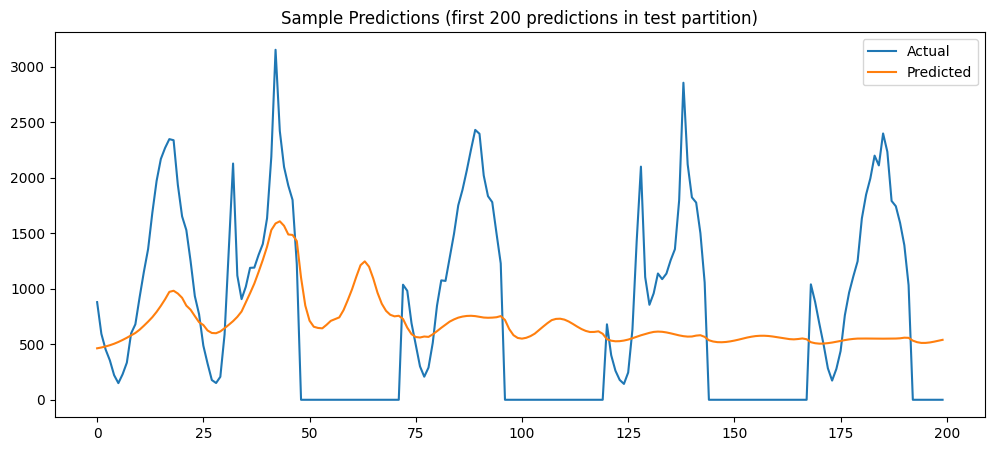

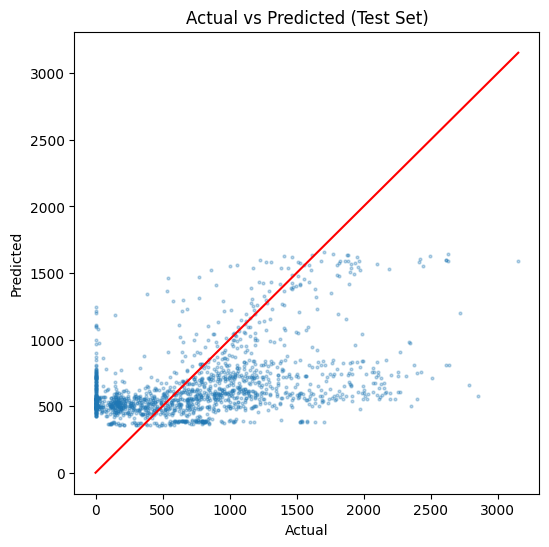

In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import random
import os
from tqdm import tqdm

# ---------------------------
# Config / Hyperparameters
# ---------------------------
csv_path = "SeoulBikeData.csv"  # change path if needed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# Sequence / training params
WINDOW_SIZE = 168       # encoder length (hours) -> 7 days
PRED_HORIZON = 1        # forecast horizon (we predict 1 hour ahead)
BATCH_SIZE = 64
EPOCHS = 50
LR = 2e-4

# ---------------------------
# 1) Load + base preprocessing
# ---------------------------
df = pd.read_csv(csv_path, encoding="latin1")
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df = df.sort_values(["Date", "Hour"]).reset_index(drop=True)

# Rename columns to consistent short names if you prefer (optional).
# But we'll use the exact names you have:
# "Rented Bike Count", "Hour", "Temperature(°C)", "Humidity(%)", "Wind speed (m/s)",
# "Visibility (10m)", "Dew point temperature(°C)", "Solar Radiation (MJ/m2)",
# "Rainfall(mm)", "Snowfall (cm)", "Seasons", "Holiday", "Functioning Day"

# ---------------------------
# 2) Feature engineering
# ---------------------------
def make_features(df):
    df = df.copy()
    # basic date parts
    df["Day"] = df["Date"].dt.day
    df["Month"] = df["Date"].dt.month
    df["DayOfWeek"] = df["Date"].dt.dayofweek
    df["WeekOfYear"] = df["Date"].dt.isocalendar().week.astype(int)

    # cyclical encodings
    df["hour_sin"] = np.sin(2 * np.pi * df["Hour"] / 24)
    df["hour_cos"] = np.cos(2 * np.pi * df["Hour"] / 24)
    df["dow_sin"] = np.sin(2 * np.pi * df["DayOfWeek"] / 7)
    df["dow_cos"] = np.cos(2 * np.pi * df["DayOfWeek"] / 7)
    df["month_sin"] = np.sin(2 * np.pi * df["Month"] / 12)
    df["month_cos"] = np.cos(2 * np.pi * df["Month"] / 12)

    # simple weather-based engineered features
    df["feels_like_temp"] = df["Temperature(°C)"] - 0.1 * df["Humidity(%)"]
    df["wind_chill"] = df["Temperature(°C)"] - 0.7 * df["Wind speed (m/s)"]
    df["visibility_scaled"] = df["Visibility (10m)"] / 1000.0
    df["temp_humidity_interaction"] = df["Temperature(°C)"] * df["Humidity(%)"]

    # boolean flags
    df["is_weekend"] = df["DayOfWeek"].isin([5, 6]).astype(int)
    df["is_morning_peak"] = df["Hour"].isin([7, 8, 9, 10]).astype(int)
    df["is_evening_peak"] = df["Hour"].isin([17, 18, 19, 20]).astype(int)
    df["is_low_demand_hour"] = df["Hour"].between(0, 5).astype(int)

    # encode holiday & functioning day reliably
    df["Holiday"] = df["Holiday"].astype(str).str.strip()
    df["Functioning Day"] = df["Functioning Day"].astype(str).str.strip()
    df["Holiday"] = df["Holiday"].map({"Holiday": 1, "No Holiday": 0}).fillna(0).astype(int)
    df["Functioning Day"] = df["Functioning Day"].map({"Yes": 1, "No": 0}).fillna(1).astype(int)

    # season -> dummies
    if "Seasons" in df.columns:
        df["Seasons"] = df["Seasons"].astype(str).str.strip()
        seasons_dummies = pd.get_dummies(df["Seasons"], prefix="Seasons")
        df = pd.concat([df, seasons_dummies], axis=1)

    # lag features and rolling means (helps LSTM even though sequence includes raw history)
    df["lag_1"] = df["Rented Bike Count"].shift(1)
    df["lag_24"] = df["Rented Bike Count"].shift(24)
    df["lag_168"] = df["Rented Bike Count"].shift(168)
    df["roll_mean_24"] = df["Rented Bike Count"].rolling(window=24).mean()
    df["roll_mean_168"] = df["Rented Bike Count"].rolling(window=168).mean()
    df = df.fillna(0)
    return df

df = make_features(df)

# ---------------------------
# 3) Chronological 80/20 split by DAYS (as asked)
# ---------------------------
unique_days = df["Date"].dt.date.unique()
n_train_days = int(len(unique_days) * 0.8)
train_days = unique_days[:n_train_days]
test_days = unique_days[n_train_days:]

train_df = df[df["Date"].dt.date.isin(train_days)].reset_index(drop=True)
test_df  = df[df["Date"].dt.date.isin(test_days)].reset_index(drop=True)

print("Train shape:", train_df.shape, "Test shape:", test_df.shape)
print("Train days:", len(train_days), "Test days:", len(test_days))

# ---------------------------
# 4) Choose feature columns and target
# ---------------------------
target_col = "Rented Bike Count"

# assemble feature list (only numeric features)
base_features = [
    "Hour", "Day", "Month", "DayOfWeek", "WeekOfYear",
    "Temperature(°C)", "Humidity(%)", "Wind speed (m/s)",
    "Visibility (10m)", "Dew point temperature(°C)",
    "Solar Radiation (MJ/m2)", "Rainfall(mm)", "Snowfall (cm)",
    "Holiday", "Functioning Day",
    "feels_like_temp", "wind_chill", "visibility_scaled",
    "temp_humidity_interaction",
    "is_weekend", "is_morning_peak", "is_evening_peak", "is_low_demand_hour",
    "lag_1", "lag_24", "lag_168", "roll_mean_24", "roll_mean_168",
    "hour_sin", "hour_cos", "dow_sin", "dow_cos", "month_sin", "month_cos"
]

# include seasons dummy columns if present
season_cols = [c for c in df.columns if c.startswith("Seasons_")]
feature_cols = base_features + season_cols

# confirm all feature columns exist
missing = [c for c in feature_cols if c not in df.columns]
if missing:
    print("WARNING: missing feature columns:", missing)
feature_cols = [c for c in feature_cols if c in df.columns]

# ---------------------------
# 5) Scaling
# ---------------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# Fit scalers on TRAIN ONLY
X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32).reshape(-1, 1)
X_test  = test_df[feature_cols].values.astype(np.float32)
y_test  = test_df[target_col].values.astype(np.float32).reshape(-1, 1)

scaler_X.fit(X_train)
scaler_y.fit(y_train)

X_train_scaled = scaler_X.transform(X_train)
X_test_scaled  = scaler_X.transform(X_test)
y_train_scaled = scaler_y.transform(y_train).flatten()
y_test_scaled  = scaler_y.transform(y_test).flatten()

# ---------------------------
# 6) Create sliding windows (sequences)
# ---------------------------
def create_sliding_windows(X, y, window_size, horizon=1, step=1):
    """
    X: (N, features)
    y: (N,) or (N,1) flattened
    returns arrays:
      X_windows: (num_windows, window_size, features)
      y_targets: (num_windows, horizon) -> here horizon=1
    """
    X_windows = []
    y_targets = []
    N = X.shape[0]
    for start in range(0, N - window_size - (horizon - 1), step):
        end = start + window_size
        target_idx = end + (horizon - 1)
        # ensure target exists
        if target_idx < N:
            X_windows.append(X[start:end])
            y_targets.append(y[target_idx])
    X_windows = np.array(X_windows)
    y_targets = np.array(y_targets)
    return X_windows, y_targets

# Build windows using train_df and test_df *as consecutive arrays*
# BUT to avoid leakage, we create windows from entire df then split by date index.
# Simpler: create windows separately for train and test using their own arrays.

X_train_seq, y_train_seq = create_sliding_windows(X_train_scaled, y_train_scaled, WINDOW_SIZE, horizon=PRED_HORIZON)
X_test_seq, y_test_seq   = create_sliding_windows(X_test_scaled, y_test_scaled, WINDOW_SIZE, horizon=PRED_HORIZON)

print("X_train_seq:", X_train_seq.shape, "y_train_seq:", y_train_seq.shape)
print("X_test_seq:", X_test_seq.shape, "y_test_seq:", y_test_seq.shape)

# ---------------------------
# 7) Torch datasets / loaders
# ---------------------------
train_dataset = TensorDataset(torch.from_numpy(X_train_seq).float(), torch.from_numpy(y_train_seq).float().unsqueeze(1))
test_dataset  = TensorDataset(torch.from_numpy(X_test_seq).float(), torch.from_numpy(y_test_seq).float().unsqueeze(1))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# ---------------------------
# 8) Model definition (Deep LSTM-GRU-Attention)
# ---------------------------
class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=128, lstm_hidden3=64, gru_hidden=64, attn_dim=64, dropout=0.3):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True)
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        # x: (batch, seq_len, features)
        out, _ = self.lstm1(x)     # -> (batch, seq_len, hidden1)
        out, _ = self.lstm2(out)   # -> (batch, seq_len, hidden2)
        out, _ = self.lstm3(out)   # -> (batch, seq_len, hidden3)
        out, _ = self.gru(out)     # -> (batch, seq_len, gru_hidden)
        # attention weights
        attn = torch.tanh(self.attn(out))            # (batch, seq_len, attn_dim)
        attn = self.attn_score(attn)                 # (batch, seq_len, 1)
        attn = torch.softmax(attn, dim=1)            # normalize across time
        attended = (out * attn).sum(dim=1)           # (batch, gru_hidden)
        attended = self.dropout(attended)
        output = self.fc(attended)                   # (batch, 1)
        return output

input_dim = X_train_seq.shape[2]
model = DeepLSTMGRUAttention(input_dim=input_dim).to(device)
print("Model parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))

# ---------------------------
# 9) Training loop with early stopping (patience)
# ---------------------------
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

best_val_loss = np.inf
patience = 6
patience_counter = 0

for epoch in range(1, EPOCHS + 1):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb = xb.to(device)
        yb = yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    avg_train_loss = np.mean(train_losses)

    # validation
    model.eval()
    val_losses = []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb = xb.to(device)
            yb = yb.to(device)
            preds = model(xb)
            val_losses.append(criterion(preds, yb).item())
    avg_val_loss = np.mean(val_losses)

    print(f"Epoch {epoch}/{EPOCHS} — train_loss: {avg_train_loss:.4f}  val_loss: {avg_val_loss:.4f}")

    # early stopping
    if avg_val_loss < best_val_loss - 1e-6:
        best_val_loss = avg_val_loss
        patience_counter = 0
        # save best model
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break

# load best model
model.load_state_dict(torch.load("best_model.pth"))

# ---------------------------
# 10) Evaluation on test set (inverse-scaling)
# ---------------------------
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        preds = model(xb)
        y_pred_all.append(preds.cpu().numpy())
        y_true_all.append(yb.cpu().numpy())

y_pred_all = np.concatenate(y_pred_all, axis=0).reshape(-1, 1)
y_true_all = np.concatenate(y_true_all, axis=0).reshape(-1, 1)

# inverse scale
y_pred_inv = scaler_y.inverse_transform(y_pred_all)
y_true_inv = scaler_y.inverse_transform(y_true_all)

# compute metrics
mse = np.mean((y_true_inv - y_pred_inv) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_inv - y_pred_inv))
# MAPE with safe denominator
safe_idx = y_true_inv.flatten() != 0
mape = np.mean(np.abs((y_true_inv[safe_idx] - y_pred_inv[safe_idx]) / y_true_inv[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_inv - y_true_inv) / (np.abs(y_true_inv) + np.abs(y_pred_inv) + 1e-8)) * 100

print("----- FINAL METRICS -----")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Test SMAPE: {smape:.2f}%")

# ---------------------------
# 11) Plot sample predictions (first 200 points)
# ---------------------------
plt.figure(figsize=(12,5))
plt.plot(y_true_inv[:200], label="Actual")
plt.plot(y_pred_inv[:200], label="Predicted")
plt.legend()
plt.title("Sample Predictions (first 200 predictions in test partition)")
plt.show()

# Optionally: scatter plot actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_true_inv, y_pred_inv, alpha=0.3, s=4)
plt.plot([y_true_inv.min(), y_true_inv.max()], [y_true_inv.min(), y_true_inv.max()], color='red')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted (Test Set)")
plt.show()


In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# =============== 1. Load & Feature Engineering =======================
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

# =============== 2. Feature List =======================
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour'
]
# Add season dummies if present
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# =============== 3. Chronological Train/Test Split =================
unique_dates = df['Date'].dt.date.unique()
n_train_days = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:n_train_days]
test_dates = unique_dates[n_train_days:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# =============== 4. Scaling Data ======================
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Train days: {len(train_dates)}, Test days: {len(test_dates)}")

# =============== 5. Deep LSTM-GRU Hybrid Model ==============
import torch
import torch.nn as nn

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=128, lstm_hidden3=64, gru_hidden=64, attn_dim=64):
        super().__init__()
        # Deep LSTM stack (now 3 layers)
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True)
        # GRU layer
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        # Attention Layer: Self-attention after GRU output (sequence-to-vector)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        # LSTM Stack
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        # GRU
        out, _ = self.gru(out)  # out: (batch, seq_len, gru_hidden)
        # Attention mechanism (Simple self-attention over time axis)
        attn_weights = torch.tanh(self.attn(out))    # (batch, seq_len, attn_dim)
        attn_weights = self.attn_score(attn_weights) # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # normalize over sequence
        attended = (out * attn_weights).sum(dim=1)         # weighted sum over time axis (self-attention)
        # Dropout & Dense Output
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

# When instantiating:
input_dim = X_train.shape[1]
model = DeepLSTMGRUAttention(input_dim)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# =============== 6. Training =====================
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 70  # Use validation for early stopping if you want, but here train for a fixed number

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}: Train Loss {np.mean(train_losses):.4f}")

# =============== 7. Model Evaluation =====================
model.eval()
mse_list = []
mae_list = []
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all_scaled = np.concatenate(y_true_all, axis=0)
y_pred_all_scaled = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all_scaled.reshape(-1,1)).flatten()
y_pred_all = scaler_y.inverse_transform(y_pred_all_scaled.reshape(-1,1)).flatten()
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all)+1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Train shape: (7008, 23), Test shape: (1752, 23)
Train days: 292, Test days: 73
Epoch 1: Train Loss 0.6968
Epoch 2: Train Loss 0.3087
Epoch 3: Train Loss 0.2563
Epoch 4: Train Loss 0.2276
Epoch 5: Train Loss 0.2024
Epoch 6: Train Loss 0.1892
Epoch 7: Train Loss 0.1796
Epoch 8: Train Loss 0.1728
Epoch 9: Train Loss 0.1690
Epoch 10: Train Loss 0.1674
Epoch 11: Train Loss 0.1622
Epoch 12: Train Loss 0.1622
Epoch 13: Train Loss 0.1590
Epoch 14: Train Loss 0.1567
Epoch 15: Train Loss 0.1570
Epoch 16: Train Loss 0.1566
Epoch 17: Train Loss 0.1533
Epoch 18: Train Loss 0.1498
Epoch 19: Train Loss 0.1483
Epoch 20: Train Loss 0.1502
Epoch 21: Train Loss 0.1472
Epoch 22: Train Loss 0.1479
Epoch 23: Train Loss 0.1471
Epoch 24: Train Loss 0.1438
Epoch 25: Train Loss 0.1414
Epoch 26: Train Loss 0.1406
Epoch 27: Train Loss 0.1388
Epoch 28: Train Loss 0.1366
Epoch 29: Train Loss 0.1390
Epoch 30: Train Loss 0.1365
Epoch 31: Train Loss 0.1330
Epoch 32: Train Loss 0.1332
Epoch 33: Train Loss 0.1326
Epoch 

simple lstm

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# --- Load & feature engineering ---
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df.sort_values(['Date', 'Hour'], inplace=True)
df.reset_index(drop=True, inplace=True)

# Add lag features
max_lag = 3
for lag in range(1, max_lag+1):
    df[f'lag_{lag}'] = df['Rented Bike Count'].shift(lag)

# Drop rows with NaNs introduced by lags
df.dropna(inplace=True)

# Map and one-hot encodings for categorical vars
df['Holiday'] = df['Holiday'].map({'No Holiday':0, 'Holiday':1})
df['Functioning Day'] = df['Functioning Day'].map({'No':0, 'Yes':1})
if 'Seasons' in df.columns:
    df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)

# Define features: numeric + engineered lags + dummies
feature_cols = [
    'Hour', 'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# --- Chronological split (80/20) ---
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)]
test_df = df[df['Date'].dt.date.isin(test_dates)]

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df['Rented Bike Count'].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df['Rented Bike Count'].values.astype(np.float32)

# --- Scaling ---
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

# Reshape for LSTM input (samples, seq_len=1, features)
X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

# Create PyTorch datasets & dataloaders
train_dataset = TensorDataset(torch.from_numpy(X_train_scaled), torch.from_numpy(y_train_scaled).unsqueeze(1))
test_dataset = TensorDataset(torch.from_numpy(X_test_scaled), torch.from_numpy(y_test_scaled).unsqueeze(1))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

# --- Model Definition ---
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=2):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_dim, 1)
    def forward(self, x):
        output, (hn, cn) = self.lstm(x)
        out = self.fc(output[:, -1, :])
        return out

input_dim = X_train_scaled.shape[2]
model = LSTMModel(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# --- Training Setup ---
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002)
criterion = nn.MSELoss()
epochs = 50

# --- Training Loop ---
for epoch in range(epochs):
    model.train()
    losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(losses):.4f}")

# --- Evaluation ---
model.eval()
y_true_list = []
y_pred_list = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_list.append(yb.cpu().numpy())
        y_pred_list.append(preds.cpu().numpy())

y_true = scaler_y.inverse_transform(np.concatenate(y_true_list, axis=0)).flatten()
y_pred = scaler_y.inverse_transform(np.concatenate(y_pred_list, axis=0)).flatten()

mse = np.mean((y_true - y_pred) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true - y_pred))
safe_idx = y_true > 10
mape = np.mean(np.abs((y_true[safe_idx] - y_pred[safe_idx]) / y_true[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Epoch 1/50, Loss: 0.6892
Epoch 2/50, Loss: 0.2477
Epoch 3/50, Loss: 0.2086
Epoch 4/50, Loss: 0.1825
Epoch 5/50, Loss: 0.1619
Epoch 6/50, Loss: 0.1525
Epoch 7/50, Loss: 0.1450
Epoch 8/50, Loss: 0.1385
Epoch 9/50, Loss: 0.1321
Epoch 10/50, Loss: 0.1292
Epoch 11/50, Loss: 0.1253
Epoch 12/50, Loss: 0.1227
Epoch 13/50, Loss: 0.1227
Epoch 14/50, Loss: 0.1178
Epoch 15/50, Loss: 0.1165
Epoch 16/50, Loss: 0.1142
Epoch 17/50, Loss: 0.1122
Epoch 18/50, Loss: 0.1118
Epoch 19/50, Loss: 0.1098
Epoch 20/50, Loss: 0.1094
Epoch 21/50, Loss: 0.1075
Epoch 22/50, Loss: 0.1054
Epoch 23/50, Loss: 0.1057
Epoch 24/50, Loss: 0.1040
Epoch 25/50, Loss: 0.1026
Epoch 26/50, Loss: 0.1013
Epoch 27/50, Loss: 0.0997
Epoch 28/50, Loss: 0.1022
Epoch 29/50, Loss: 0.0985
Epoch 30/50, Loss: 0.0976
Epoch 31/50, Loss: 0.0962
Epoch 32/50, Loss: 0.0968
Epoch 33/50, Loss: 0.0959
Epoch 34/50, Loss: 0.0958
Epoch 35/50, Loss: 0.0956
Epoch 36/50, Loss: 0.0918
Epoch 37/50, Loss: 0.0947
Epoch 38/50, Loss: 0.0925
Epoch 39/50, Loss: 0.

LSTM ?GRU with the new  LSTM code

In [9]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# -------------------- 1. Load and Feature Engineering --------------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df, max_lag=3)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# -------------------- 2. Chronological Train/Test Split --------------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# -------------------- 3. Scaling --------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# -------------------- 4. Model: LSTM-GRU Hybrid --------------------
class LSTMGRUHybrid(nn.Module):
    def __init__(self, input_dim, lstm_hidden=128, gru_hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, lstm_hidden, batch_first=True)
        self.gru = nn.GRU(lstm_hidden, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(gru_hidden, 1)
    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        gru_out, _ = self.gru(lstm_out)
        out = self.dropout(gru_out[:, -1, :])
        out = self.fc(out)
        return out

input_dim = X_train_scaled.shape[2]
model = LSTMGRUHybrid(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 70

# -------------------- 5. Training Loop --------------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(train_losses):.4f}")

# -------------------- 6. Evaluation --------------------
model.eval()
y_true_all = []
y_pred_all = []
mse_list = []
mae_list = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all)
y_pred_all = scaler_y.inverse_transform(y_pred_all)
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_mask = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_mask] - y_pred_all[safe_mask]) / y_true_all[safe_mask])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Train samples: 7005, Test samples: 1752
Epoch 1/70, Loss: 0.5304
Epoch 2/70, Loss: 0.1809
Epoch 3/70, Loss: 0.1494
Epoch 4/70, Loss: 0.1295
Epoch 5/70, Loss: 0.1163
Epoch 6/70, Loss: 0.1072
Epoch 7/70, Loss: 0.1008
Epoch 8/70, Loss: 0.0970
Epoch 9/70, Loss: 0.0932
Epoch 10/70, Loss: 0.0896
Epoch 11/70, Loss: 0.0884
Epoch 12/70, Loss: 0.0868
Epoch 13/70, Loss: 0.0854
Epoch 14/70, Loss: 0.0836
Epoch 15/70, Loss: 0.0835
Epoch 16/70, Loss: 0.0805
Epoch 17/70, Loss: 0.0782
Epoch 18/70, Loss: 0.0781
Epoch 19/70, Loss: 0.0762
Epoch 20/70, Loss: 0.0738
Epoch 21/70, Loss: 0.0733
Epoch 22/70, Loss: 0.0727
Epoch 23/70, Loss: 0.0710
Epoch 24/70, Loss: 0.0710
Epoch 25/70, Loss: 0.0704
Epoch 26/70, Loss: 0.0702
Epoch 27/70, Loss: 0.0675
Epoch 28/70, Loss: 0.0677
Epoch 29/70, Loss: 0.0678
Epoch 30/70, Loss: 0.0661
Epoch 31/70, Loss: 0.0657
Epoch 32/70, Loss: 0.0651
Epoch 33/70, Loss: 0.0638
Epoch 34/70, Loss: 0.0651
Epoch 35/70, Loss: 0.0639
Epoch 36/70, Loss: 0.0643
Epoch 37/70, Loss: 0.0636
Epoch 3

adding attention mechanism

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# -------------------- 1. Load and Feature Engineering --------------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df, max_lag=3)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# -------------------- 2. Chronological Train/Test Split --------------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# -------------------- 3. Scaling --------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# -------------------- 4. Model: LSTM-GRU Hybrid --------------------
class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=128, lstm_hidden3=64, gru_hidden=64, attn_dim=64):
        super().__init__()
        # Three stacked LSTM layers for deep temporal feature extraction
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True)
        
        # GRU layer to capture sequence relationships efficiently
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True)
        
        # Dropout layer to reduce overfitting
        self.dropout = nn.Dropout(0.3)
        
        # Self-attention mechanism
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        
        # Fully connected layer for final output
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)  # Shape: (batch, seq_len, gru_hidden)
        
        # Attention calculation
        attn_weights = torch.tanh(self.attn(out))      # (batch, seq_len, attn_dim)
        attn_weights = self.attn_score(attn_weights)   # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # Normalize over sequence length
        
        # Weighted sum over the sequence dimension
        attended = (out * attn_weights).sum(dim=1)
        
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output


input_dim = X_train_scaled.shape[2]
model = LSTMGRUHybrid(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 100

# -------------------- 5. Training Loop --------------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(train_losses):.4f}")

# -------------------- 6. Evaluation --------------------
model.eval()
y_true_all = []
y_pred_all = []
mse_list = []
mae_list = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all)
y_pred_all = scaler_y.inverse_transform(y_pred_all)
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_mask = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_mask] - y_pred_all[safe_mask]) / y_true_all[safe_mask])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")

Train samples: 7005, Test samples: 1752
Epoch 1/100, Loss: 0.4905
Epoch 2/100, Loss: 0.1800
Epoch 3/100, Loss: 0.1494
Epoch 4/100, Loss: 0.1282
Epoch 5/100, Loss: 0.1149
Epoch 6/100, Loss: 0.1047
Epoch 7/100, Loss: 0.0990
Epoch 8/100, Loss: 0.0932
Epoch 9/100, Loss: 0.0916
Epoch 10/100, Loss: 0.0894
Epoch 11/100, Loss: 0.0885
Epoch 12/100, Loss: 0.0852
Epoch 13/100, Loss: 0.0831
Epoch 14/100, Loss: 0.0839
Epoch 15/100, Loss: 0.0820
Epoch 16/100, Loss: 0.0805
Epoch 17/100, Loss: 0.0790
Epoch 18/100, Loss: 0.0782
Epoch 19/100, Loss: 0.0756
Epoch 20/100, Loss: 0.0741
Epoch 21/100, Loss: 0.0733
Epoch 22/100, Loss: 0.0718
Epoch 23/100, Loss: 0.0722
Epoch 24/100, Loss: 0.0701
Epoch 25/100, Loss: 0.0711
Epoch 26/100, Loss: 0.0694
Epoch 27/100, Loss: 0.0684
Epoch 28/100, Loss: 0.0686
Epoch 29/100, Loss: 0.0680
Epoch 30/100, Loss: 0.0667
Epoch 31/100, Loss: 0.0662
Epoch 32/100, Loss: 0.0646
Epoch 33/100, Loss: 0.0651
Epoch 34/100, Loss: 0.0656
Epoch 35/100, Loss: 0.0654
Epoch 36/100, Loss: 0.06

changing the drouput 

In [26]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# -------------------- 1. Load and Feature Engineering --------------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df, max_lag=3)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# -------------------- 2. Chronological Train/Test Split --------------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# -------------------- 3. Scaling --------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# -------------------- 4. Model: LSTM-GRU Hybrid --------------------
class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=128, lstm_hidden3=64, gru_hidden=64, attn_dim=64):
        super().__init__()
        # Three stacked LSTM layers for deep temporal feature extraction
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True)
        
        # GRU layer to capture sequence relationships efficiently
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True)
        
        # Dropout layer to reduce overfitting
        self.dropout = nn.Dropout(0.4)
        
        # Self-attention mechanism
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        
        # Fully connected layer for final output
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)  # Shape: (batch, seq_len, gru_hidden)
        
        # Attention calculation
        attn_weights = torch.tanh(self.attn(out))      # (batch, seq_len, attn_dim)
        attn_weights = self.attn_score(attn_weights)   # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # Normalize over sequence length
        
        # Weighted sum over the sequence dimension
        attended = (out * attn_weights).sum(dim=1)
        
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output


input_dim = X_train_scaled.shape[2]
model = LSTMGRUHybrid(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 100

# -------------------- 5. Training Loop --------------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(train_losses):.4f}")

# -------------------- 6. Evaluation --------------------
model.eval()
y_true_all = []
y_pred_all = []
mse_list = []
mae_list = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all)
y_pred_all = scaler_y.inverse_transform(y_pred_all)
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_mask = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_mask] - y_pred_all[safe_mask]) / y_true_all[safe_mask])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")

Train samples: 7005, Test samples: 1752
Epoch 1/100, Loss: 0.5098
Epoch 2/100, Loss: 0.1803
Epoch 3/100, Loss: 0.1493
Epoch 4/100, Loss: 0.1281
Epoch 5/100, Loss: 0.1130
Epoch 6/100, Loss: 0.1044
Epoch 7/100, Loss: 0.0999
Epoch 8/100, Loss: 0.0955
Epoch 9/100, Loss: 0.0927
Epoch 10/100, Loss: 0.0917
Epoch 11/100, Loss: 0.0895
Epoch 12/100, Loss: 0.0862
Epoch 13/100, Loss: 0.0855
Epoch 14/100, Loss: 0.0829
Epoch 15/100, Loss: 0.0810
Epoch 16/100, Loss: 0.0789
Epoch 17/100, Loss: 0.0803
Epoch 18/100, Loss: 0.0783
Epoch 19/100, Loss: 0.0770
Epoch 20/100, Loss: 0.0762
Epoch 21/100, Loss: 0.0739
Epoch 22/100, Loss: 0.0733
Epoch 23/100, Loss: 0.0733
Epoch 24/100, Loss: 0.0710
Epoch 25/100, Loss: 0.0701
Epoch 26/100, Loss: 0.0702
Epoch 27/100, Loss: 0.0683
Epoch 28/100, Loss: 0.0691
Epoch 29/100, Loss: 0.0677
Epoch 30/100, Loss: 0.0674
Epoch 31/100, Loss: 0.0665
Epoch 32/100, Loss: 0.0656
Epoch 33/100, Loss: 0.0639
Epoch 34/100, Loss: 0.0652
Epoch 35/100, Loss: 0.0637
Epoch 36/100, Loss: 0.06

added another LSTM layer

In [32]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

# -------------------- 1. Load and Feature Engineering --------------------
df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5, 6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7, 8, 9, 10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17, 18, 19, 20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0, 5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag + 1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df, max_lag=3)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)',
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# -------------------- 2. Chronological Train/Test Split --------------------
unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# -------------------- 3. Scaling --------------------
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Train samples: {X_train.shape[0]}, Test samples: {X_test.shape[0]}")

# -------------------- 4. Model: LSTM-GRU Hybrid --------------------
class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=128, lstm_hidden2=128,  lstm_hidden3=64, gru_hidden=128, attn_dim=64):
        super().__init__()
        # Three stacked LSTM layers for deep temporal feature extraction
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True)
        # self.lstm4 = nn.LSTM(lstm_hidden3, lstm_hidden4, batch_first=True)
        
        # GRU layer to capture sequence relationships efficiently
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True)
        
        # Dropout layer to reduce overfitting
        self.dropout = nn.Dropout(0.4)
        
        # Self-attention mechanism
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        
        # Fully connected layer for final output
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)  # Shape: (batch, seq_len, gru_hidden)
        
        # Attention calculation
        attn_weights = torch.tanh(self.attn(out))      # (batch, seq_len, attn_dim)
        attn_weights = self.attn_score(attn_weights)   # (batch, seq_len, 1)
        attn_weights = torch.softmax(attn_weights, dim=1)  # Normalize over sequence length
        
        # Weighted sum over the sequence dimension
        attended = (out * attn_weights).sum(dim=1)
        
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output


input_dim = X_train_scaled.shape[2]
model = LSTMGRUHybrid(input_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 100

# -------------------- 5. Training Loop --------------------
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss: {np.mean(train_losses):.4f}")

# -------------------- 6. Evaluation --------------------
model.eval()
y_true_all = []
y_pred_all = []
mse_list = []
mae_list = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        mse_list.append(nn.functional.mse_loss(preds, yb).item())
        mae_list.append(nn.functional.l1_loss(preds, yb).item())
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all)
y_pred_all = scaler_y.inverse_transform(y_pred_all)
mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_mask = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_mask] - y_pred_all[safe_mask]) / y_true_all[safe_mask])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")

Train samples: 7005, Test samples: 1752
Epoch 1/100, Loss: 0.5286
Epoch 2/100, Loss: 0.1822
Epoch 3/100, Loss: 0.1521
Epoch 4/100, Loss: 0.1310
Epoch 5/100, Loss: 0.1169
Epoch 6/100, Loss: 0.1072
Epoch 7/100, Loss: 0.0981
Epoch 8/100, Loss: 0.0958
Epoch 9/100, Loss: 0.0928
Epoch 10/100, Loss: 0.0909
Epoch 11/100, Loss: 0.0852
Epoch 12/100, Loss: 0.0860
Epoch 13/100, Loss: 0.0835
Epoch 14/100, Loss: 0.0815
Epoch 15/100, Loss: 0.0795
Epoch 16/100, Loss: 0.0804
Epoch 17/100, Loss: 0.0795
Epoch 18/100, Loss: 0.0771
Epoch 19/100, Loss: 0.0745
Epoch 20/100, Loss: 0.0737
Epoch 21/100, Loss: 0.0723
Epoch 22/100, Loss: 0.0711
Epoch 23/100, Loss: 0.0706
Epoch 24/100, Loss: 0.0702
Epoch 25/100, Loss: 0.0706
Epoch 26/100, Loss: 0.0706
Epoch 27/100, Loss: 0.0678
Epoch 28/100, Loss: 0.0678
Epoch 29/100, Loss: 0.0672
Epoch 30/100, Loss: 0.0655
Epoch 31/100, Loss: 0.0652
Epoch 32/100, Loss: 0.0651
Epoch 33/100, Loss: 0.0656
Epoch 34/100, Loss: 0.0643
Epoch 35/100, Loss: 0.0638
Epoch 36/100, Loss: 0.06

adding XGBoost

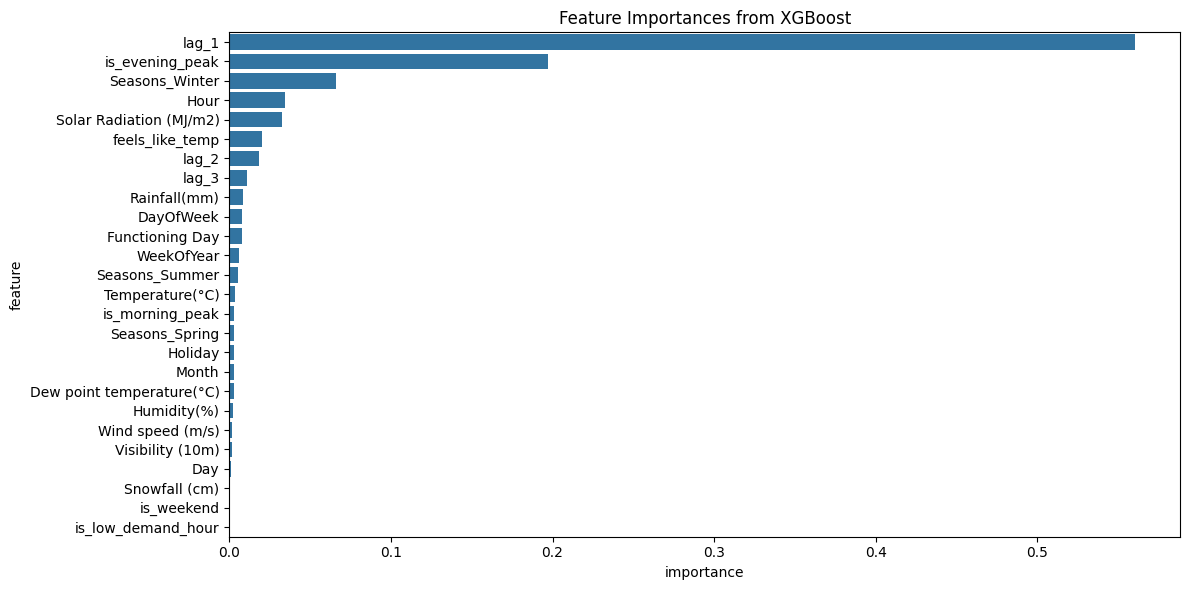

Selected features: ['lag_1', 'is_evening_peak', 'Seasons_Winter', 'Hour', 'Solar Radiation (MJ/m2)', 'feels_like_temp', 'lag_2', 'lag_3', 'Rainfall(mm)', 'DayOfWeek', 'Functioning Day', 'WeekOfYear', 'Seasons_Summer', 'Temperature(°C)', 'is_morning_peak', 'Seasons_Spring', 'Holiday', 'Month', 'Dew point temperature(°C)', 'Humidity(%)']
Training on 7005 samples with 20 features.
Epoch 1/100: Loss 0.4938
Epoch 2/100: Loss 0.1700
Epoch 3/100: Loss 0.1336
Epoch 4/100: Loss 0.1203
Epoch 5/100: Loss 0.1097
Epoch 6/100: Loss 0.1031
Epoch 7/100: Loss 0.0996
Epoch 8/100: Loss 0.0951
Epoch 9/100: Loss 0.0935
Epoch 10/100: Loss 0.0897
Epoch 11/100: Loss 0.0889
Epoch 12/100: Loss 0.0854
Epoch 13/100: Loss 0.0826
Epoch 14/100: Loss 0.0813
Epoch 15/100: Loss 0.0789
Epoch 16/100: Loss 0.0803
Epoch 17/100: Loss 0.0772
Epoch 18/100: Loss 0.0768
Epoch 19/100: Loss 0.0778
Epoch 20/100: Loss 0.0764
Epoch 21/100: Loss 0.0743
Epoch 22/100: Loss 0.0740
Epoch 23/100: Loss 0.0745
Epoch 24/100: Loss 0.0736
Epoc

In [21]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Feature Engineering ---

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

# Add lag features and basic engineered features
def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

# Initial feature list before feature selection
feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# --- 2. Chronological Train/Test Split (80/20) ---

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# --- 3. Feature Selection with XGBoost ---

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title("Feature Importances from XGBoost")
plt.tight_layout()
plt.show()

# Select top N features (e.g., top 15)
top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
print("Selected features:", selected_features)

# Filter train and test data to selected features
X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# --- 4. Scaling ---

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Training on {X_train_scaled.shape[0]} samples with {X_train_scaled.shape[2]} features.")

# --- 5. Define LSTM-GRU Hybrid Model with Attention ---

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=256, lstm_hidden2=128, lstm_hidden3=128, gru_hidden=64, attn_dim=64):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True)
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True)
        self.dropout = nn.Dropout(0.4)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)
        attn_weights = torch.tanh(self.attn(out))
        attn_weights = self.attn_score(attn_weights)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = (out * attn_weights).sum(dim=1)
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

input_dim = X_train_scaled.shape[2]
model = DeepLSTMGRUAttention(input_dim)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 100

# --- 6. Training Loop ---
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 7. Evaluation ---
model.eval()
y_true_all = []
y_pred_all = []
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)
y_true_all = scaler_y.inverse_transform(y_true_all)
y_pred_all = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


tweaking params

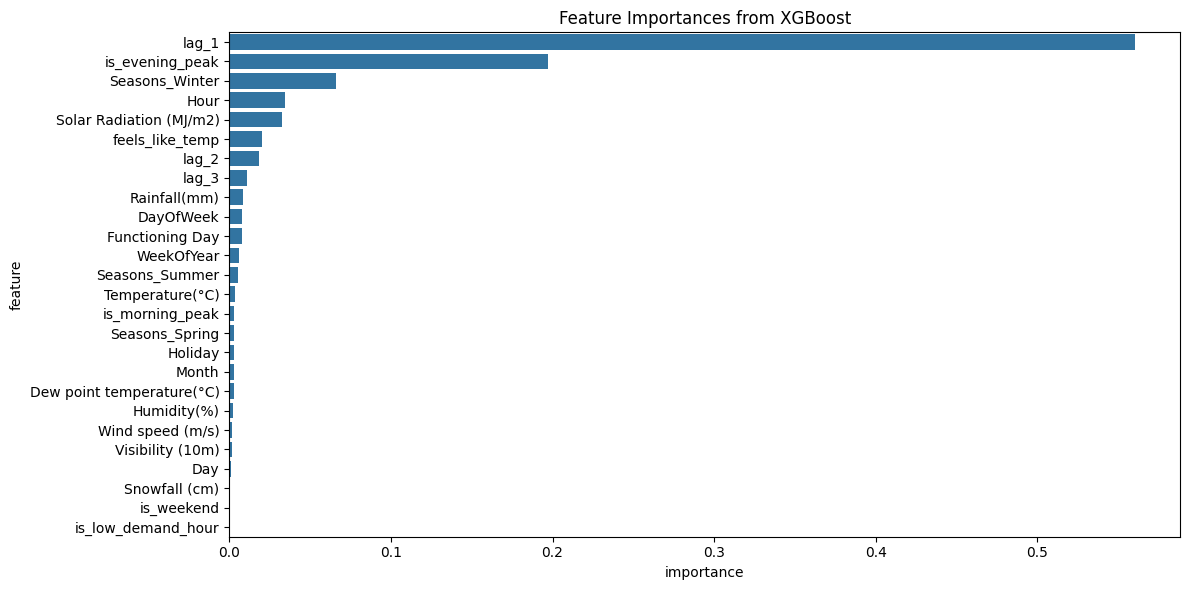

Selected features: ['lag_1', 'is_evening_peak', 'Seasons_Winter', 'Hour', 'Solar Radiation (MJ/m2)', 'feels_like_temp', 'lag_2', 'lag_3', 'Rainfall(mm)', 'DayOfWeek', 'Functioning Day', 'WeekOfYear', 'Seasons_Summer', 'Temperature(°C)', 'is_morning_peak', 'Seasons_Spring', 'Holiday', 'Month', 'Dew point temperature(°C)', 'Humidity(%)']
Training on 7005 samples with 20 features.


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Epoch 1/100: Loss 0.5170
Epoch 2/100: Loss 0.1742
Epoch 3/100: Loss 0.1412
Epoch 4/100: Loss 0.1213
Epoch 5/100: Loss 0.1133
Epoch 6/100: Loss 0.1050
Epoch 7/100: Loss 0.1006
Epoch 8/100: Loss 0.0954
Epoch 9/100: Loss 0.0963
Epoch 10/100: Loss 0.0922
Epoch 11/100: Loss 0.0864
Epoch 12/100: Loss 0.0838
Epoch 13/100: Loss 0.0844
Epoch 14/100: Loss 0.0817
Epoch 15/100: Loss 0.0811
Epoch 16/100: Loss 0.0798
Epoch 17/100: Loss 0.0786
Epoch 18/100: Loss 0.0777
Epoch 19/100: Loss 0.0775
Epoch 20/100: Loss 0.0768
Epoch 21/100: Loss 0.0744
Epoch 22/100: Loss 0.0747
Epoch 23/100: Loss 0.0731
Epoch 24/100: Loss 0.0726
Epoch 25/100: Loss 0.0730
Epoch 26/100: Loss 0.0736
Epoch 27/100: Loss 0.0712
Epoch 28/100: Loss 0.0704
Epoch 29/100: Loss 0.0721
Epoch 30/100: Loss 0.0702
Epoch 31/100: Loss 0.0710
Epoch 32/100: Loss 0.0684
Epoch 33/100: Loss 0.0695
Epoch 34/100: Loss 0.0673
Epoch 35/100: Loss 0.0676
Epoch 36/100: Loss 0.0674
Epoch 37/100: Loss 0.0660
Epoch 38/100: Loss 0.0676
Epoch 39/100: Loss 0.

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Feature Engineering ---

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# --- 2. Chronological Train/Test Split (80/20) ---

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# --- 3. Feature Selection with XGBoost ---

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title("Feature Importances from XGBoost")
plt.tight_layout()
plt.show()

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
print("Selected features:", selected_features)

X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# --- 4. Scaling ---

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Training on {X_train_scaled.shape[0]} samples with {X_train_scaled.shape[2]} features.")

# --- 5. Define LSTM-GRU Hybrid Model with Attention with dropout ---

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=256, lstm_hidden2=128, lstm_hidden3=128, gru_hidden=64, attn_dim=64, dropout=0.4):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True, dropout=dropout, num_layers=1)
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True, dropout=dropout, num_layers=1)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)
        attn_weights = torch.tanh(self.attn(out))
        attn_weights = self.attn_score(attn_weights)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = (out * attn_weights).sum(dim=1)
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

input_dim = X_train_scaled.shape[2]
model = DeepLSTMGRUAttention(input_dim, dropout=0.4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer with L2 weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 100

# --- 6. Training Loop ---

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 7. Evaluation ---

model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all = scaler_y.inverse_transform(y_true_all)
y_pred_all = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


adding norm after gru

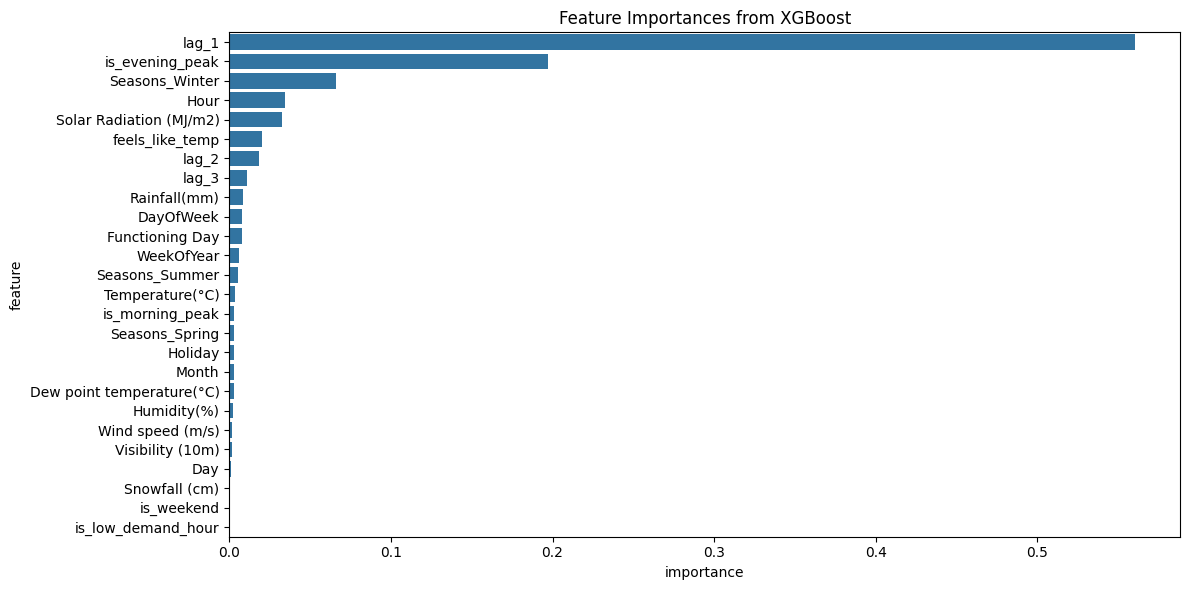

Selected features: ['lag_1', 'is_evening_peak', 'Seasons_Winter', 'Hour', 'Solar Radiation (MJ/m2)', 'feels_like_temp', 'lag_2', 'lag_3', 'Rainfall(mm)', 'DayOfWeek', 'Functioning Day', 'WeekOfYear', 'Seasons_Summer', 'Temperature(°C)', 'is_morning_peak', 'Seasons_Spring', 'Holiday', 'Month', 'Dew point temperature(°C)', 'Humidity(%)']
Training on 7005 samples with 20 features.


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Epoch 1/100: Loss 0.5163
Epoch 2/100: Loss 0.1723
Epoch 3/100: Loss 0.1397
Epoch 4/100: Loss 0.1169
Epoch 5/100: Loss 0.1089
Epoch 6/100: Loss 0.1057
Epoch 7/100: Loss 0.1009
Epoch 8/100: Loss 0.0958
Epoch 9/100: Loss 0.0932
Epoch 10/100: Loss 0.0913
Epoch 11/100: Loss 0.0903
Epoch 12/100: Loss 0.0888
Epoch 13/100: Loss 0.0835
Epoch 14/100: Loss 0.0819
Epoch 15/100: Loss 0.0830
Epoch 16/100: Loss 0.0790
Epoch 17/100: Loss 0.0813
Epoch 18/100: Loss 0.0776
Epoch 19/100: Loss 0.0770
Epoch 20/100: Loss 0.0765
Epoch 21/100: Loss 0.0753
Epoch 22/100: Loss 0.0760
Epoch 23/100: Loss 0.0745
Epoch 24/100: Loss 0.0754
Epoch 25/100: Loss 0.0735
Epoch 26/100: Loss 0.0745
Epoch 27/100: Loss 0.0722
Epoch 28/100: Loss 0.0745
Epoch 29/100: Loss 0.0730
Epoch 30/100: Loss 0.0737
Epoch 31/100: Loss 0.0720
Epoch 32/100: Loss 0.0711
Epoch 33/100: Loss 0.0733
Epoch 34/100: Loss 0.0710
Epoch 35/100: Loss 0.0675
Epoch 36/100: Loss 0.0684
Epoch 37/100: Loss 0.0679
Epoch 38/100: Loss 0.0669
Epoch 39/100: Loss 0.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Feature Engineering ---

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# --- 2. Chronological Train/Test Split (80/20) ---

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# --- 3. Feature Selection with XGBoost ---

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title("Feature Importances from XGBoost")
plt.tight_layout()
plt.show()

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
print("Selected features:", selected_features)

X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# --- 4. Scaling ---

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Training on {X_train_scaled.shape[0]} samples with {X_train_scaled.shape[2]} features.")

# --- 5. Define LSTM-GRU Hybrid Model with Attention with dropout ---

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=256, lstm_hidden2=128, lstm_hidden3=128, gru_hidden=64, attn_dim=64, dropout=0.4):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True, dropout=dropout, num_layers=1)
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True, dropout=dropout, num_layers=1)
        self.bn = nn.BatchNorm1d(gru_hidden)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)
        attn_weights = torch.tanh(self.attn(out))
        attn_weights = self.attn_score(attn_weights)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = (out * attn_weights).sum(dim=1)
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

input_dim = X_train_scaled.shape[2]
model = DeepLSTMGRUAttention(input_dim, dropout=0.4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer with L2 weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 100

# --- 6. Training Loop ---

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 7. Evaluation ---

model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all = scaler_y.inverse_transform(y_true_all)
y_pred_all = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


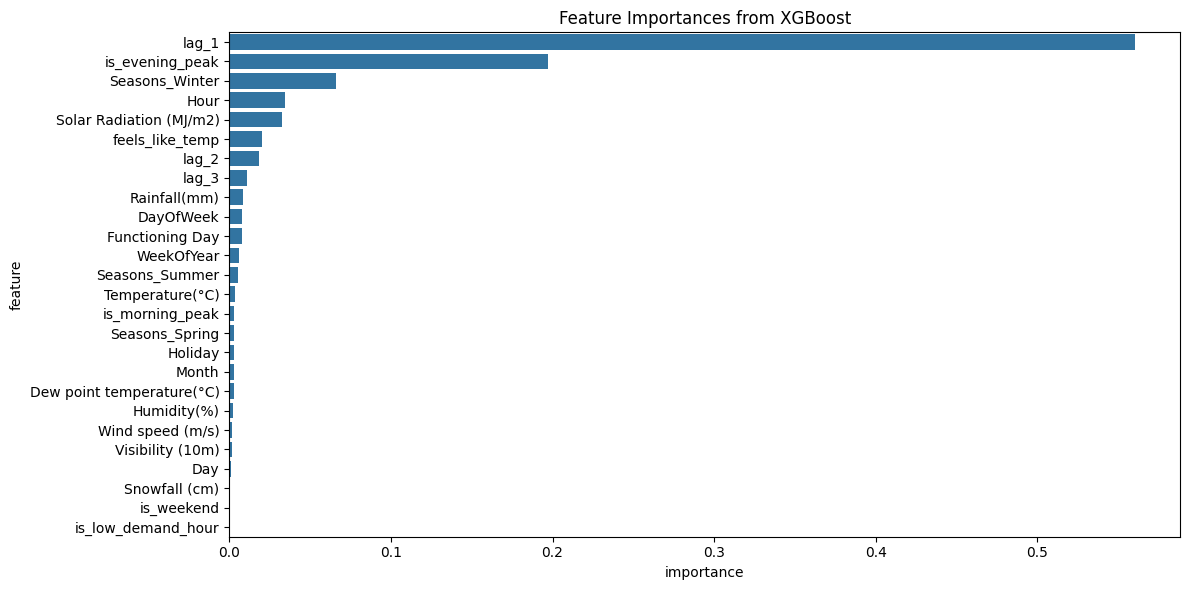

Selected features: ['lag_1', 'is_evening_peak', 'Seasons_Winter', 'Hour', 'Solar Radiation (MJ/m2)', 'feels_like_temp', 'lag_2', 'lag_3', 'Rainfall(mm)', 'DayOfWeek', 'Functioning Day', 'WeekOfYear', 'Seasons_Summer', 'Temperature(°C)', 'is_morning_peak', 'Seasons_Spring', 'Holiday', 'Month', 'Dew point temperature(°C)', 'Humidity(%)']
Training on 7005 samples with 20 features.


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Epoch 1/100: Loss 0.4938
Epoch 2/100: Loss 0.1673
Epoch 3/100: Loss 0.1400
Epoch 4/100: Loss 0.1221
Epoch 5/100: Loss 0.1116
Epoch 6/100: Loss 0.1057
Epoch 7/100: Loss 0.1017
Epoch 8/100: Loss 0.0970
Epoch 9/100: Loss 0.0964
Epoch 10/100: Loss 0.0905
Epoch 11/100: Loss 0.0886
Epoch 12/100: Loss 0.0843
Epoch 13/100: Loss 0.0824
Epoch 14/100: Loss 0.0813
Epoch 15/100: Loss 0.0777
Epoch 16/100: Loss 0.0783
Epoch 17/100: Loss 0.0769
Epoch 18/100: Loss 0.0759
Epoch 19/100: Loss 0.0763
Epoch 20/100: Loss 0.0743
Epoch 21/100: Loss 0.0755
Epoch 22/100: Loss 0.0729
Epoch 23/100: Loss 0.0743
Epoch 24/100: Loss 0.0761
Epoch 25/100: Loss 0.0744
Epoch 26/100: Loss 0.0747
Epoch 27/100: Loss 0.0732
Epoch 28/100: Loss 0.0738
Epoch 29/100: Loss 0.0693
Epoch 30/100: Loss 0.0742
Epoch 31/100: Loss 0.0727
Epoch 32/100: Loss 0.0722
Epoch 33/100: Loss 0.0711
Epoch 34/100: Loss 0.0708
Epoch 35/100: Loss 0.0694
Epoch 36/100: Loss 0.0708
Epoch 37/100: Loss 0.0682
Epoch 38/100: Loss 0.0692
Epoch 39/100: Loss 0.

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Feature Engineering ---

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# --- 2. Chronological Train/Test Split (80/20) ---

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# --- 3. Feature Selection with XGBoost ---

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title("Feature Importances from XGBoost")
plt.tight_layout()
plt.show()

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
print("Selected features:", selected_features)

X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# --- 4. Scaling ---

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Training on {X_train_scaled.shape[0]} samples with {X_train_scaled.shape[2]} features.")

# --- 5. Define LSTM-GRU Hybrid Model with Attention with dropout ---

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=256, lstm_hidden2=128, lstm_hidden3=128, gru_hidden=64, attn_dim=64, dropout=0.4):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True, dropout=dropout, num_layers=1)
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True, dropout=dropout, num_layers=1)
        self.bn = nn.BatchNorm1d(gru_hidden)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)# out: (batch, seq_len, gru_hidden)
# BatchNorm expects (batch, features, seq_len) or (batch, features); we can permute
        out_bn = self.bn(out.permute(0, 2, 1)).permute(0, 2, 1)
        attn_weights = torch.tanh(self.attn(out_bn))
        attn_weights = self.attn_score(attn_weights)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = (out * attn_weights).sum(dim=1)
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

input_dim = X_train_scaled.shape[2]
model = DeepLSTMGRUAttention(input_dim, dropout=0.4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer with L2 weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 100

# --- 6. Training Loop ---

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 7. Evaluation ---

model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all = scaler_y.inverse_transform(y_true_all)
y_pred_all = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


adding weight decay to optimizer from the stable code

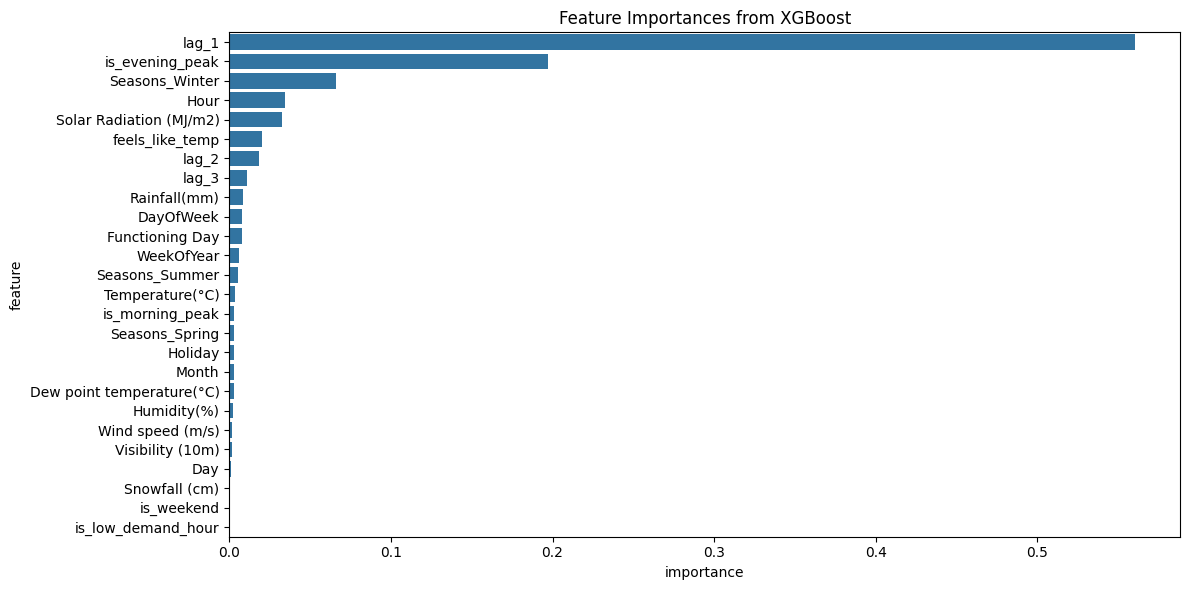

Selected features: ['lag_1', 'is_evening_peak', 'Seasons_Winter', 'Hour', 'Solar Radiation (MJ/m2)', 'feels_like_temp', 'lag_2', 'lag_3', 'Rainfall(mm)', 'DayOfWeek', 'Functioning Day', 'WeekOfYear', 'Seasons_Summer', 'Temperature(°C)', 'is_morning_peak', 'Seasons_Spring', 'Holiday', 'Month', 'Dew point temperature(°C)', 'Humidity(%)']
Training on 7005 samples with 20 features.


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Epoch 1/100: Loss 0.5090
Epoch 2/100: Loss 0.1682
Epoch 3/100: Loss 0.1364
Epoch 4/100: Loss 0.1187
Epoch 5/100: Loss 0.1065
Epoch 6/100: Loss 0.1047
Epoch 7/100: Loss 0.1004
Epoch 8/100: Loss 0.0952
Epoch 9/100: Loss 0.0910
Epoch 10/100: Loss 0.0897
Epoch 11/100: Loss 0.0864
Epoch 12/100: Loss 0.0849
Epoch 13/100: Loss 0.0846
Epoch 14/100: Loss 0.0830
Epoch 15/100: Loss 0.0806
Epoch 16/100: Loss 0.0786
Epoch 17/100: Loss 0.0795
Epoch 18/100: Loss 0.0790
Epoch 19/100: Loss 0.0784
Epoch 20/100: Loss 0.0769
Epoch 21/100: Loss 0.0758
Epoch 22/100: Loss 0.0757
Epoch 23/100: Loss 0.0736
Epoch 24/100: Loss 0.0730
Epoch 25/100: Loss 0.0719
Epoch 26/100: Loss 0.0720
Epoch 27/100: Loss 0.0729
Epoch 28/100: Loss 0.0725
Epoch 29/100: Loss 0.0696
Epoch 30/100: Loss 0.0710
Epoch 31/100: Loss 0.0697
Epoch 32/100: Loss 0.0698
Epoch 33/100: Loss 0.0694
Epoch 34/100: Loss 0.0688
Epoch 35/100: Loss 0.0695
Epoch 36/100: Loss 0.0670
Epoch 37/100: Loss 0.0673
Epoch 38/100: Loss 0.0673
Epoch 39/100: Loss 0.

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Feature Engineering ---

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# --- 2. Chronological Train/Test Split (80/20) ---

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# --- 3. Feature Selection with XGBoost ---

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title("Feature Importances from XGBoost")
plt.tight_layout()
plt.show()

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
print("Selected features:", selected_features)

X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# --- 4. Scaling ---

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Training on {X_train_scaled.shape[0]} samples with {X_train_scaled.shape[2]} features.")

# --- 5. Define LSTM-GRU Hybrid Model with Attention with dropout ---

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=256, lstm_hidden2=128, lstm_hidden3=128, gru_hidden=64, attn_dim=64, dropout=0.4):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True, dropout=dropout, num_layers=1)
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True, dropout=dropout, num_layers=1)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)
        attn_weights = torch.tanh(self.attn(out))
        attn_weights = self.attn_score(attn_weights)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = (out * attn_weights).sum(dim=1)
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

input_dim = X_train_scaled.shape[2]
model = DeepLSTMGRUAttention(input_dim, dropout=0.4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer with L2 weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)
criterion = nn.MSELoss()
epochs = 100

# --- 6. Training Loop ---

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 7. Evaluation ---

model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all = scaler_y.inverse_transform(y_true_all)
y_pred_all = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Gradient clipping for stable training from stable code

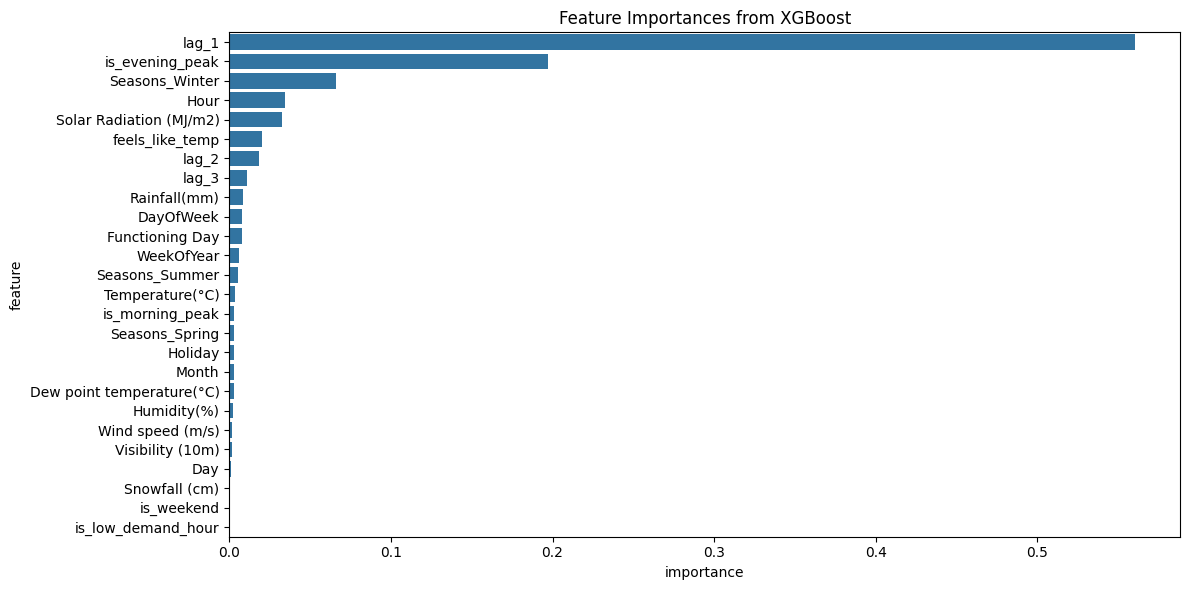

Selected features: ['lag_1', 'is_evening_peak', 'Seasons_Winter', 'Hour', 'Solar Radiation (MJ/m2)', 'feels_like_temp', 'lag_2', 'lag_3', 'Rainfall(mm)', 'DayOfWeek', 'Functioning Day', 'WeekOfYear', 'Seasons_Summer', 'Temperature(°C)', 'is_morning_peak', 'Seasons_Spring', 'Holiday', 'Month', 'Dew point temperature(°C)', 'Humidity(%)']
Training on 7005 samples with 20 features.


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Epoch 1/100: Loss 0.5070
Epoch 2/100: Loss 0.1693
Epoch 3/100: Loss 0.1371
Epoch 4/100: Loss 0.1176
Epoch 5/100: Loss 0.1088
Epoch 6/100: Loss 0.1036
Epoch 7/100: Loss 0.1020
Epoch 8/100: Loss 0.0939
Epoch 9/100: Loss 0.0943
Epoch 10/100: Loss 0.0901
Epoch 11/100: Loss 0.0874
Epoch 12/100: Loss 0.0845
Epoch 13/100: Loss 0.0841
Epoch 14/100: Loss 0.0823
Epoch 15/100: Loss 0.0793
Epoch 16/100: Loss 0.0818
Epoch 17/100: Loss 0.0789
Epoch 18/100: Loss 0.0778
Epoch 19/100: Loss 0.0763
Epoch 20/100: Loss 0.0777
Epoch 21/100: Loss 0.0754
Epoch 22/100: Loss 0.0759
Epoch 23/100: Loss 0.0747
Epoch 24/100: Loss 0.0733
Epoch 25/100: Loss 0.0733
Epoch 26/100: Loss 0.0709
Epoch 27/100: Loss 0.0711
Epoch 28/100: Loss 0.0712
Epoch 29/100: Loss 0.0719
Epoch 30/100: Loss 0.0708
Epoch 31/100: Loss 0.0724
Epoch 32/100: Loss 0.0702
Epoch 33/100: Loss 0.0696
Epoch 34/100: Loss 0.0693
Epoch 35/100: Loss 0.0689
Epoch 36/100: Loss 0.0682
Epoch 37/100: Loss 0.0704
Epoch 38/100: Loss 0.0695
Epoch 39/100: Loss 0.

In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Feature Engineering ---

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# --- 2. Chronological Train/Test Split (80/20) ---

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# --- 3. Feature Selection with XGBoost ---

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title("Feature Importances from XGBoost")
plt.tight_layout()
plt.show()

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
print("Selected features:", selected_features)

X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# --- 4. Scaling ---

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Training on {X_train_scaled.shape[0]} samples with {X_train_scaled.shape[2]} features.")

# --- 5. Define LSTM-GRU Hybrid Model with Attention with dropout ---

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=256, lstm_hidden2=128, lstm_hidden3=128, gru_hidden=64, attn_dim=64, dropout=0.4):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True, dropout=dropout, num_layers=1)
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True, dropout=dropout, num_layers=1)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)
        attn_weights = torch.tanh(self.attn(out))
        attn_weights = self.attn_score(attn_weights)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = (out * attn_weights).sum(dim=1)
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

input_dim = X_train_scaled.shape[2]
model = DeepLSTMGRUAttention(input_dim, dropout=0.4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer with L2 weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 100

# --- 6. Training Loop ---

for epoch in range(epochs):
    model.train()
    train_losses = []
    # for xb, yb in train_loader:
    #     xb, yb = xb.to(device), yb.to(device)
    #     optimizer.zero_grad()
    #     preds = model(xb)
    #     loss = criterion(preds, yb)
    #     loss.backward()
    #     optimizer.step()
    #     train_losses.append(loss.item())
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())

    print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 7. Evaluation ---

model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all = scaler_y.inverse_transform(y_true_all)
y_pred_all = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Try a slightly smaller model variant (capacity balancing) after stable code

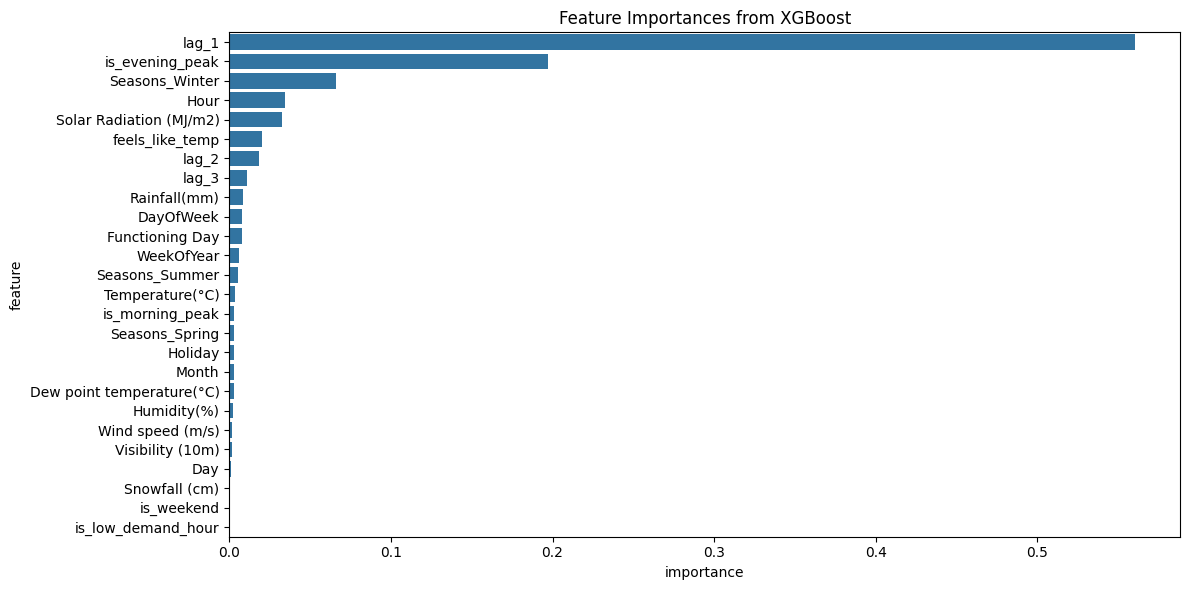

Selected features: ['lag_1', 'is_evening_peak', 'Seasons_Winter', 'Hour', 'Solar Radiation (MJ/m2)', 'feels_like_temp', 'lag_2', 'lag_3', 'Rainfall(mm)', 'DayOfWeek', 'Functioning Day', 'WeekOfYear', 'Seasons_Summer', 'Temperature(°C)', 'is_morning_peak', 'Seasons_Spring', 'Holiday', 'Month', 'Dew point temperature(°C)', 'Humidity(%)']
Training on 7005 samples with 20 features.


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Epoch 1/100: Loss 0.5719
Epoch 2/100: Loss 0.1817
Epoch 3/100: Loss 0.1429
Epoch 4/100: Loss 0.1261
Epoch 5/100: Loss 0.1106
Epoch 6/100: Loss 0.1073
Epoch 7/100: Loss 0.1022
Epoch 8/100: Loss 0.0984
Epoch 9/100: Loss 0.0959
Epoch 10/100: Loss 0.0937
Epoch 11/100: Loss 0.0869
Epoch 12/100: Loss 0.0855
Epoch 13/100: Loss 0.0841
Epoch 14/100: Loss 0.0820
Epoch 15/100: Loss 0.0798
Epoch 16/100: Loss 0.0811
Epoch 17/100: Loss 0.0806
Epoch 18/100: Loss 0.0781
Epoch 19/100: Loss 0.0760
Epoch 20/100: Loss 0.0767
Epoch 21/100: Loss 0.0748
Epoch 22/100: Loss 0.0749
Epoch 23/100: Loss 0.0720
Epoch 24/100: Loss 0.0737
Epoch 25/100: Loss 0.0735
Epoch 26/100: Loss 0.0719
Epoch 27/100: Loss 0.0719
Epoch 28/100: Loss 0.0715
Epoch 29/100: Loss 0.0699
Epoch 30/100: Loss 0.0698
Epoch 31/100: Loss 0.0695
Epoch 32/100: Loss 0.0705
Epoch 33/100: Loss 0.0706
Epoch 34/100: Loss 0.0718
Epoch 35/100: Loss 0.0676
Epoch 36/100: Loss 0.0686
Epoch 37/100: Loss 0.0678
Epoch 38/100: Loss 0.0678
Epoch 39/100: Loss 0.

In [7]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Feature Engineering ---

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# --- 2. Chronological Train/Test Split (80/20) ---

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# --- 3. Feature Selection with XGBoost ---

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title("Feature Importances from XGBoost")
plt.tight_layout()
plt.show()

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
print("Selected features:", selected_features)

X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# --- 4. Scaling ---

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Training on {X_train_scaled.shape[0]} samples with {X_train_scaled.shape[2]} features.")

# --- 5. Define LSTM-GRU Hybrid Model with Attention with dropout ---

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=256, lstm_hidden2=128, lstm_hidden3=128, gru_hidden=64, attn_dim=64, dropout=0.4):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True, dropout=dropout, num_layers=1)
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True, dropout=dropout, num_layers=1)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)
        attn_weights = torch.tanh(self.attn(out))
        attn_weights = self.attn_score(attn_weights)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = (out * attn_weights).sum(dim=1)
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

input_dim = X_train_scaled.shape[2]
# model = DeepLSTMGRUAttention(input_dim, dropout=0.4)
model = DeepLSTMGRUAttention(input_dim,
                             lstm_hidden1=192,
                             lstm_hidden2=128,
                             lstm_hidden3=64,
                             gru_hidden=64,
                             attn_dim=64,
                             dropout=0.4)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer with L2 weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 100

# --- 6. Training Loop ---

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    # for xb, yb in train_loader:
    #     xb, yb = xb.to(device), yb.to(device)
    #     optimizer.zero_grad()
    #     preds = model(xb)
    #     loss = criterion(preds, yb)
    #     loss.backward()
    #     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    #     optimizer.step()
    #     train_losses.append(loss.item())

    print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 7. Evaluation ---

model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all = scaler_y.inverse_transform(y_true_all)
y_pred_all = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


Simple learning-rate schedule (manual “decay”) after stable code

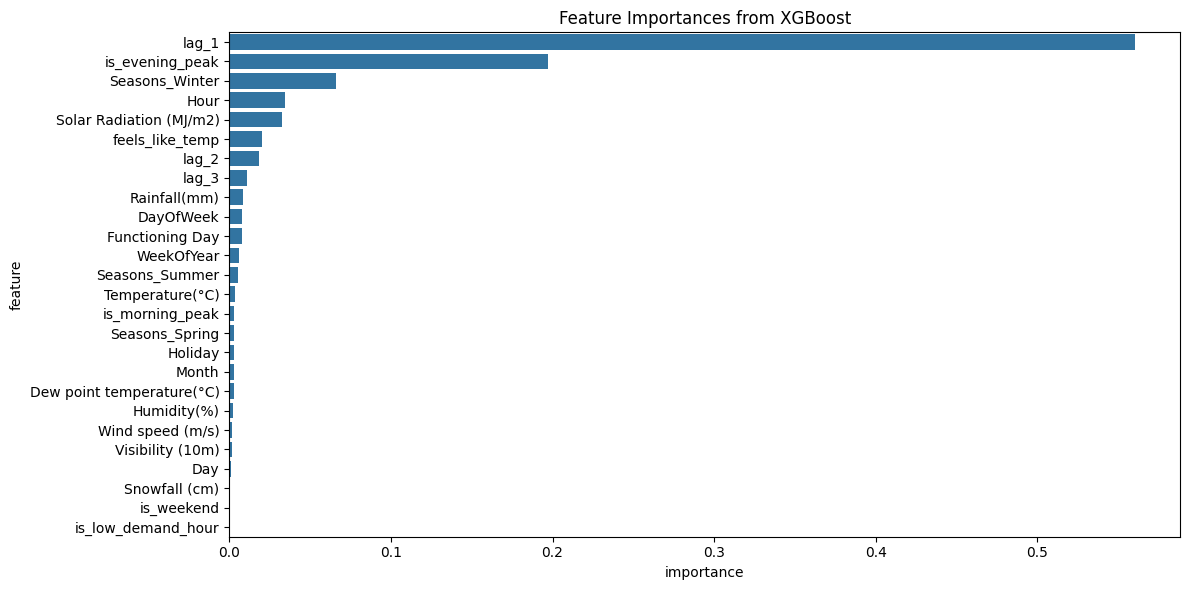

Selected features: ['lag_1', 'is_evening_peak', 'Seasons_Winter', 'Hour', 'Solar Radiation (MJ/m2)', 'feels_like_temp', 'lag_2', 'lag_3', 'Rainfall(mm)', 'DayOfWeek', 'Functioning Day', 'WeekOfYear', 'Seasons_Summer', 'Temperature(°C)', 'is_morning_peak', 'Seasons_Spring', 'Holiday', 'Month', 'Dew point temperature(°C)', 'Humidity(%)']
Training on 7005 samples with 20 features.


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Epoch 1/100: Loss 0.4991
Epoch 2/100: Loss 0.1680
Epoch 3/100: Loss 0.1382
Epoch 4/100: Loss 0.1173
Epoch 5/100: Loss 0.1104
Epoch 6/100: Loss 0.1081
Epoch 7/100: Loss 0.1005
Epoch 8/100: Loss 0.0979
Epoch 9/100: Loss 0.0956
Epoch 10/100: Loss 0.0910
Epoch 11/100: Loss 0.0889
Epoch 12/100: Loss 0.0875
Epoch 13/100: Loss 0.0833
Epoch 14/100: Loss 0.0823
Epoch 15/100: Loss 0.0814
Epoch 16/100: Loss 0.0814
Epoch 17/100: Loss 0.0785
Epoch 18/100: Loss 0.0780
Epoch 19/100: Loss 0.0788
Epoch 20/100: Loss 0.0785
Epoch 21/100: Loss 0.0750
Epoch 22/100: Loss 0.0748
Epoch 23/100: Loss 0.0756
Epoch 24/100: Loss 0.0761
Epoch 25/100: Loss 0.0732
Epoch 26/100: Loss 0.0728
Epoch 27/100: Loss 0.0737
Epoch 28/100: Loss 0.0732
Epoch 29/100: Loss 0.0717
Epoch 30/100: Loss 0.0738
Epoch 31/100: Loss 0.0723
Epoch 32/100: Loss 0.0709
Epoch 33/100: Loss 0.0717
Epoch 34/100: Loss 0.0702
Epoch 35/100: Loss 0.0705
Epoch 36/100: Loss 0.0697
Epoch 37/100: Loss 0.0701
Epoch 38/100: Loss 0.0684
Epoch 39/100: Loss 0.

In [8]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Feature Engineering ---

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# --- 2. Chronological Train/Test Split (80/20) ---

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# --- 3. Feature Selection with XGBoost ---

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title("Feature Importances from XGBoost")
plt.tight_layout()
plt.show()

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
print("Selected features:", selected_features)

X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# --- 4. Scaling ---

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Training on {X_train_scaled.shape[0]} samples with {X_train_scaled.shape[2]} features.")

# --- 5. Define LSTM-GRU Hybrid Model with Attention with dropout ---

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=256, lstm_hidden2=128, lstm_hidden3=128, gru_hidden=64, attn_dim=64, dropout=0.4):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True, dropout=dropout, num_layers=1)
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True, dropout=dropout, num_layers=1)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)
        attn_weights = torch.tanh(self.attn(out))
        attn_weights = self.attn_score(attn_weights)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = (out * attn_weights).sum(dim=1)
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

input_dim = X_train_scaled.shape[2]
model = DeepLSTMGRUAttention(input_dim, dropout=0.4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer with L2 weight decay for regularization
# optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=60, gamma=0.5)

criterion = nn.MSELoss()
epochs = 100

# --- 6. Training Loop ---

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    

    print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # if you added clipping
        optimizer.step()
        train_losses.append(loss.item())
    scheduler.step()
    print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")


# --- 7. Evaluation ---

model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all = scaler_y.inverse_transform(y_true_all)
y_pred_all = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


24 hr context window

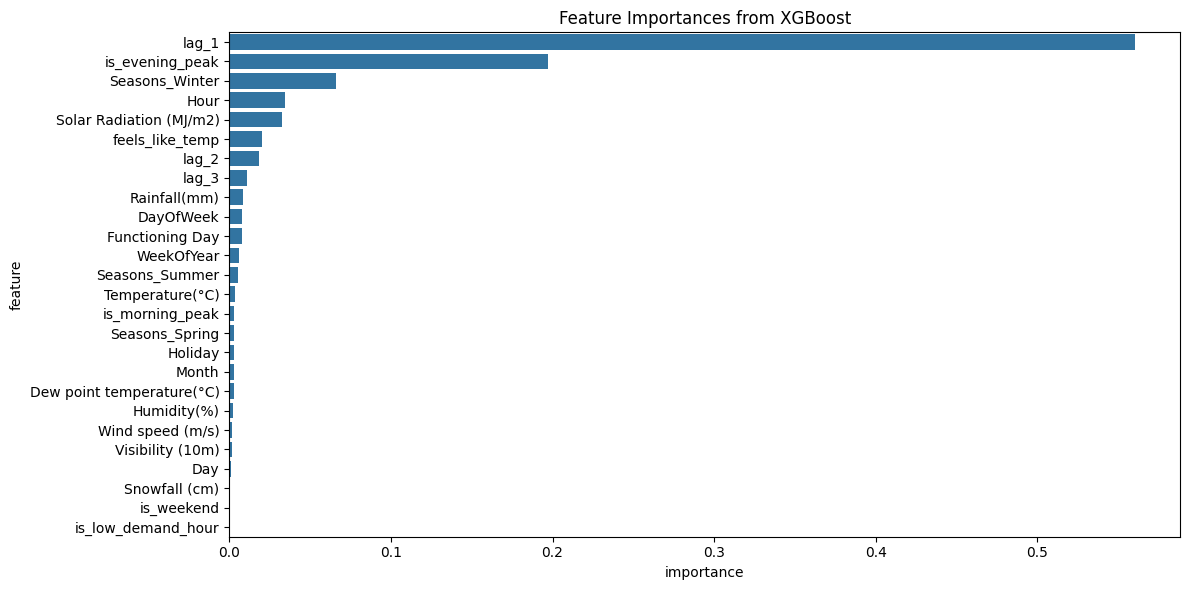

Selected features: ['lag_1', 'is_evening_peak', 'Seasons_Winter', 'Hour', 'Solar Radiation (MJ/m2)', 'feels_like_temp', 'lag_2', 'lag_3', 'Rainfall(mm)', 'DayOfWeek', 'Functioning Day', 'WeekOfYear', 'Seasons_Summer', 'Temperature(°C)', 'is_morning_peak', 'Seasons_Spring', 'Holiday', 'Month', 'Dew point temperature(°C)', 'Humidity(%)']
Windowed shapes - Train: (6981, 24, 20), Test: (1728, 24, 20)
Final input shape: (batch, 24, 20)


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Epoch 10/100: Loss 0.1563
Epoch 20/100: Loss 0.1031
Epoch 30/100: Loss 0.0654
Epoch 40/100: Loss 0.0507
Epoch 50/100: Loss 0.0451
Epoch 60/100: Loss 0.0312
Epoch 70/100: Loss 0.0244
Epoch 80/100: Loss 0.0219
Epoch 90/100: Loss 0.0198
Epoch 100/100: Loss 0.0243
Test MSE: 108785.0469
Test RMSE: 329.8258
Test MAE: 227.0081
Test MAPE: 77.48% (filtered zeros)
Test SMAPE: 53.04%


In [12]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Feature Engineering (UNCHANGED) ---

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# --- 2. YOUR ORIGINAL XGBoost Feature Selection (UNCHANGED) ---

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title("Feature Importances from XGBoost")
plt.tight_layout()
plt.show()

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
print("Selected features:", selected_features)

# --- 3. SIMPLIFIED Windowing on SELECTED FEATURES ONLY ---

window_size = 24
X_train_win, y_train_win = [], []
X_test_win, y_test_win = [], []

# Window train data using ONLY selected features
for i in range(window_size, len(train_df)):
    X_train_win.append(train_df[selected_features].iloc[i-window_size:i].values)
    y_train_win.append(train_df[target_col].iloc[i])

# Window test data using ONLY selected features  
for i in range(window_size, len(test_df)):
    X_test_win.append(test_df[selected_features].iloc[i-window_size:i].values)
    y_test_win.append(test_df[target_col].iloc[i])

X_train_win = np.array(X_train_win, dtype=np.float32)  # (train_samples, 24, 20)
y_train_win = np.array(y_train_win, dtype=np.float32)
X_test_win = np.array(X_test_win, dtype=np.float32)     # (test_samples, 24, 20)
y_test_win = np.array(y_test_win, dtype=np.float32)

print(f"Windowed shapes - Train: {X_train_win.shape}, Test: {X_test_win.shape}")

# --- 4. Scaling ---

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_flat = X_train_win.reshape(-1, X_train_win.shape[-1])
X_test_flat = X_test_win.reshape(-1, X_test_win.shape[-1])
X_train_scaled_flat = scaler_X.fit_transform(X_train_flat)
X_test_scaled_flat = scaler_X.transform(X_test_flat)

X_train_scaled = X_train_scaled_flat.reshape(X_train_win.shape)
X_test_scaled = X_test_scaled_flat.reshape(X_test_win.shape)

y_train_scaled = scaler_y.fit_transform(y_train_win.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test_win.reshape(-1,1)).flatten()

# Tensors
X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Final input shape: (batch, {X_train_scaled.shape[1]}, {X_train_scaled.shape[2]})")

# --- 5. FIXED Model for Windowed Input ---

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, dropout=0.2):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, 256, batch_first=True, dropout=dropout)
        self.lstm2 = nn.LSTM(256, 128, batch_first=True, dropout=dropout)
        self.lstm3 = nn.LSTM(128, 128, batch_first=True, dropout=dropout)
        self.gru = nn.GRU(128, 64, batch_first=True, dropout=dropout)
        
        # Multi-head attention for sequences
        self.attn = nn.MultiheadAttention(64, num_heads=8, batch_first=True, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(64, 1)

    def forward(self, x):  # x: (batch, 24, 20)
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)  # (batch, 24, 64)
        
        attn_out, _ = self.attn(out, out, out)
        out = out + attn_out  # residual
        
        # Pool over time dimension
        pooled = out.mean(dim=1)  # (batch, 64)
        pooled = self.dropout(pooled)
        output = self.fc(pooled)
        return output

input_dim = X_train_scaled.shape[2]
model = DeepLSTMGRUAttention(input_dim, dropout=0.2)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 100

# --- 6. Training ---
for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 7. Evaluation ---
model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all)
y_pred_all = np.concatenate(y_pred_all)

y_true_all = scaler_y.inverse_transform(y_true_all)
y_pred_all = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all.flatten() > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


new try changing batch size

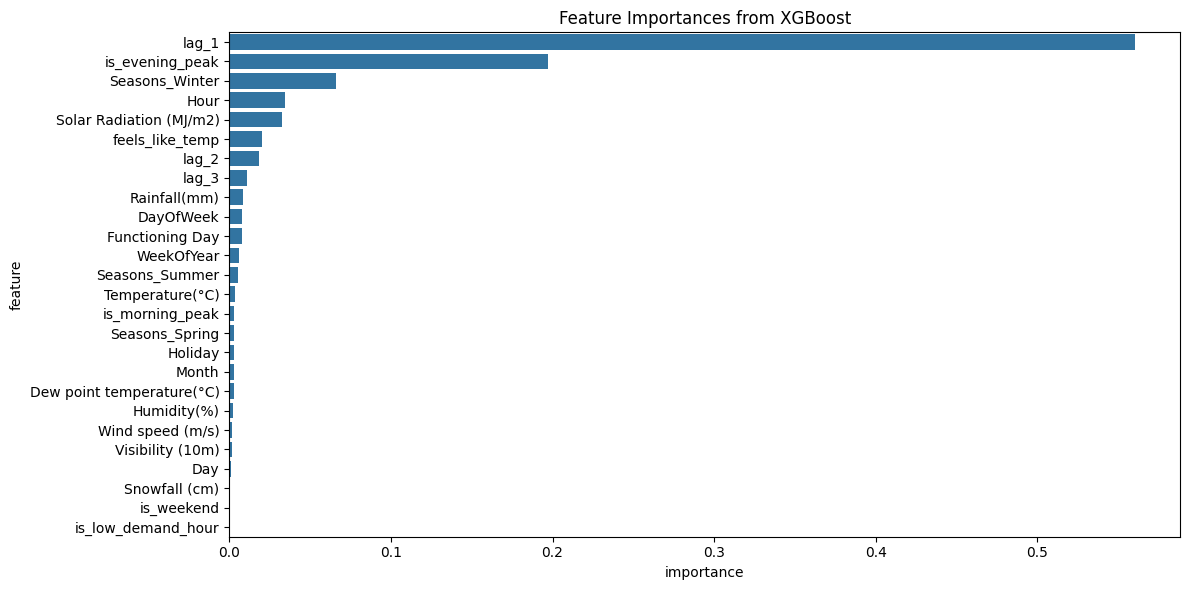

Selected features: ['lag_1', 'is_evening_peak', 'Seasons_Winter', 'Hour', 'Solar Radiation (MJ/m2)', 'feels_like_temp', 'lag_2', 'lag_3', 'Rainfall(mm)', 'DayOfWeek', 'Functioning Day', 'WeekOfYear', 'Seasons_Summer', 'Temperature(°C)', 'is_morning_peak', 'Seasons_Spring', 'Holiday', 'Month', 'Dew point temperature(°C)', 'Humidity(%)']
Training on 7005 samples with 20 features.


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Epoch 1/100: Loss 0.7652
Epoch 2/100: Loss 0.2119
Epoch 3/100: Loss 0.1678
Epoch 4/100: Loss 0.1465
Epoch 5/100: Loss 0.1295
Epoch 6/100: Loss 0.1201
Epoch 7/100: Loss 0.1134
Epoch 8/100: Loss 0.1070
Epoch 9/100: Loss 0.1055
Epoch 10/100: Loss 0.1011
Epoch 11/100: Loss 0.0995
Epoch 12/100: Loss 0.0943
Epoch 13/100: Loss 0.0928
Epoch 14/100: Loss 0.0926
Epoch 15/100: Loss 0.0876
Epoch 16/100: Loss 0.0848
Epoch 17/100: Loss 0.0856
Epoch 18/100: Loss 0.0829
Epoch 19/100: Loss 0.0816
Epoch 20/100: Loss 0.0801
Epoch 21/100: Loss 0.0792
Epoch 22/100: Loss 0.0789
Epoch 23/100: Loss 0.0761
Epoch 24/100: Loss 0.0783
Epoch 25/100: Loss 0.0767
Epoch 26/100: Loss 0.0757
Epoch 27/100: Loss 0.0755
Epoch 28/100: Loss 0.0746
Epoch 29/100: Loss 0.0736
Epoch 30/100: Loss 0.0735
Epoch 31/100: Loss 0.0733
Epoch 32/100: Loss 0.0736
Epoch 33/100: Loss 0.0737
Epoch 34/100: Loss 0.0715
Epoch 35/100: Loss 0.0751
Epoch 36/100: Loss 0.0717
Epoch 37/100: Loss 0.0717
Epoch 38/100: Loss 0.0714
Epoch 39/100: Loss 0.

In [13]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Feature Engineering ---

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# --- 2. Chronological Train/Test Split (80/20) ---

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# --- 3. Feature Selection with XGBoost ---

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title("Feature Importances from XGBoost")
plt.tight_layout()
plt.show()

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
print("Selected features:", selected_features)

X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# --- 4. Scaling ---

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

print(f"Training on {X_train_scaled.shape[0]} samples with {X_train_scaled.shape[2]} features.")

# --- 5. Define LSTM-GRU Hybrid Model with Attention with dropout ---

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=256, lstm_hidden2=128, lstm_hidden3=128, gru_hidden=64, attn_dim=64, dropout=0.4):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True, dropout=dropout, num_layers=1)
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True, dropout=dropout, num_layers=1)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)
        attn_weights = torch.tanh(self.attn(out))
        attn_weights = self.attn_score(attn_weights)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = (out * attn_weights).sum(dim=1)
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

input_dim = X_train_scaled.shape[2]
model = DeepLSTMGRUAttention(input_dim, dropout=0.4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer with L2 weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 100

# --- 6. Training Loop ---

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 7. Evaluation ---

model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all = scaler_y.inverse_transform(y_true_all)
y_pred_all = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Feature Engineering (SAME AS ALWAYS) ---

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# --- 2. Train/Test Split + XGBoost (BASELINE WINNER) ---

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train_full = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test_full = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# XGBoost (uses ALL 26 features)
print("🚀 Training XGBoost...")
xgb_model = XGBRegressor(random_state=42, n_jobs=-1, max_depth=6)
xgb_model.fit(X_train_full, y_train)
xgb_pred = xgb_model.predict(X_test_full)
xgb_rmse = np.sqrt(np.mean((y_test - xgb_pred)**2))
print(f"✅ XGBoost RMSE: {xgb_rmse:.1f}")

# Feature selection for LSTM (top 20)
importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values('importance', ascending=False)
selected_features = feat_imp_df['feature'].iloc[:20].tolist()

X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# --- 3. LSTM-GRU (YOUR ORIGINAL WINNER) ---

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

# Single timestep
X_train_scaled = X_train_scaled.reshape(-1, 1, X_train_scaled.shape[1])
X_test_scaled = X_test_scaled.reshape(-1, 1, X_test_scaled.shape[1])

X_train_torch = torch.from_numpy(X_train_scaled).float()
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1).float()
X_test_torch = torch.from_numpy(X_test_scaled).float()
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1).float()

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

# YOUR ORIGINAL LSTM-GRU ARCHITECTURE
class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=256, lstm_hidden2=128, lstm_hidden3=128, gru_hidden=64, attn_dim=64, dropout=0.4):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True, dropout=dropout, num_layers=1)
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True, dropout=dropout, num_layers=1)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)
        attn_weights = torch.tanh(self.attn(out))
        attn_weights = self.attn_score(attn_weights)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = (out * attn_weights).sum(dim=1)
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

# Train LSTM-GRU
input_dim = X_train_scaled.shape[2]
lstm_model = DeepLSTMGRUAttention(input_dim, dropout=0.4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model.to(device)

optimizer = torch.optim.Adam(lstm_model.parameters(), lr=1e-4, weight_decay=1e-5)
criterion = nn.MSELoss()

print("🚀 Training LSTM-GRU...")
for epoch in range(100):
    lstm_model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = lstm_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(lstm_model.parameters(), max_norm=1.0)
        optimizer.step()
        train_losses.append(loss.item())
    
    if (epoch + 1) % 20 == 0:
        print(f"LSTM Epoch {epoch+1}: Loss {np.mean(train_losses):.4f}")

# LSTM predictions
lstm_model.eval()
lstm_preds_scaled = []
with torch.no_grad():
    for xb, _ in test_loader:
        xb = xb.to(device)
        preds = lstm_model(xb)
        lstm_preds_scaled.append(preds.cpu().numpy())

lstm_preds_scaled = np.concatenate(lstm_preds_scaled)
lstm_preds_orig = scaler_y.inverse_transform(lstm_preds_scaled)
lstm_rmse = np.sqrt(np.mean((y_test - lstm_preds_orig)**2))

# --- 4. ENSEMBLE MAGIC 🔥 ---

# Test different weights
weights = [0.8, 0.7, 0.6, 0.5, 0.4]
best_rmse = float('inf')
best_weight = 0

print("\n🔥 ENSEMBLE TESTING...")
for w_xgb in weights:
    w_lstm = 1 - w_xgb
    ensemble_pred = w_xgb * xgb_pred + w_lstm * lstm_preds_orig
    
    ensemble_rmse = np.sqrt(np.mean((y_test - ensemble_pred)**2))
    print(f"XGBoost {w_xgb:.1f} + LSTM {w_lstm:.1f}: RMSE {ensemble_rmse:.1f}")
    
    if ensemble_rmse < best_rmse:
        best_rmse = ensemble_rmse
        best_weight = w_xgb

print("\n" + "═"*100)
print("🏆 FINAL RESULTS COMPARISON")
print("═"*100)
print(f"⚡ XGBoost only:          RMSE {xgb_rmse:6.1f}")
print(f"🎯 LSTM-GRU only:         RMSE {lstm_rmse:6.1f}")
print(f"🔥 BEST ENSEMBLE:         RMSE {best_rmse:6.1f}  (XGBoost {best_weight:.1f} + LSTM {1-best_weight:.1f})")
print(f"🎯 Improvement:           {xgb_rmse-best_rmse:.1f} points better than XGBoost alone!")
print("═"*100)


🚀 Training XGBoost...
✅ XGBoost RMSE: 160.1


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


🚀 Training LSTM-GRU...
LSTM Epoch 20: Loss 0.1125
LSTM Epoch 40: Loss 0.0917
LSTM Epoch 60: Loss 0.0820
LSTM Epoch 80: Loss 0.0751
LSTM Epoch 100: Loss 0.0728

🔥 ENSEMBLE TESTING...
XGBoost 0.8 + LSTM 0.2: RMSE 241.7
XGBoost 0.7 + LSTM 0.3: RMSE 309.8
XGBoost 0.6 + LSTM 0.4: RMSE 384.2
XGBoost 0.5 + LSTM 0.5: RMSE 461.8
XGBoost 0.4 + LSTM 0.6: RMSE 541.4

════════════════════════════════════════════════════════════════════════════════════════════════════
🏆 FINAL RESULTS COMPARISON
════════════════════════════════════════════════════════════════════════════════════════════════════
⚡ XGBoost only:          RMSE  160.1
🎯 LSTM-GRU only:         RMSE  867.9
🔥 BEST ENSEMBLE:         RMSE  241.7  (XGBoost 0.8 + LSTM 0.2)
🎯 Improvement:           -81.6 points better than XGBoost alone!
════════════════════════════════════════════════════════════════════════════════════════════════════


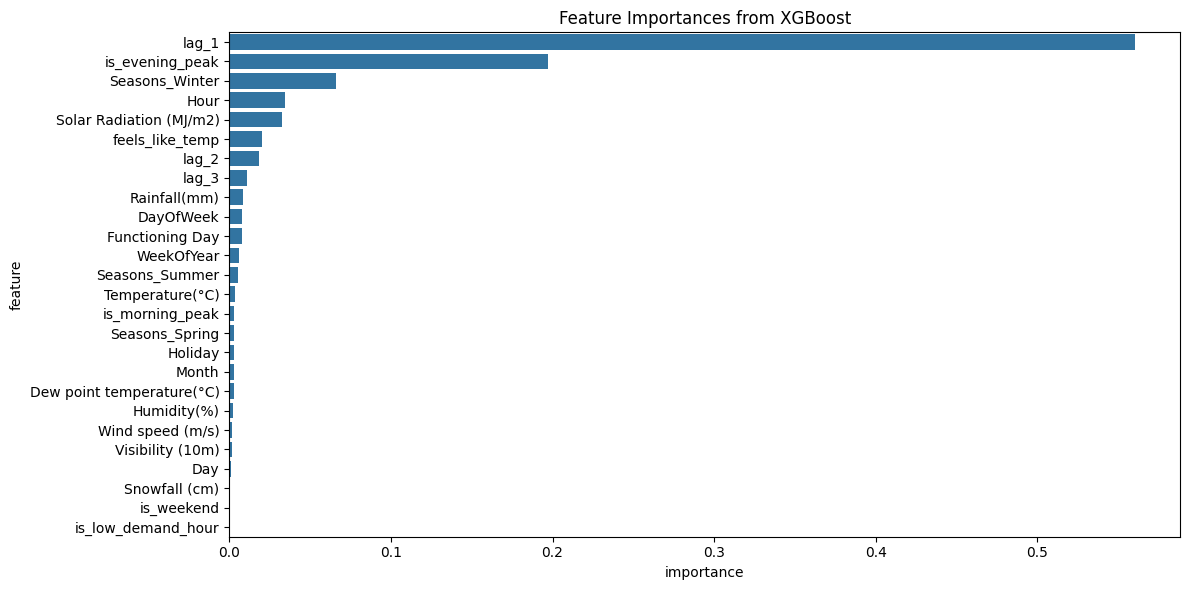

Selected features: ['lag_1', 'is_evening_peak', 'Seasons_Winter', 'Hour', 'Solar Radiation (MJ/m2)', 'feels_like_temp', 'lag_2', 'lag_3', 'Rainfall(mm)', 'DayOfWeek', 'Functioning Day', 'WeekOfYear', 'Seasons_Summer', 'Temperature(°C)', 'is_morning_peak', 'Seasons_Spring', 'Holiday', 'Month', 'Dew point temperature(°C)', 'Humidity(%)']
Training on 7005 samples with 20 features.


d:\SRH\Github\Improving-Forecasting-Accuracy-in-Bike-Rental-Demand-through-Advanced-Deep-Learning-Models\.venv\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4 and num_layers=1
  warnings.warn(


Epoch 1/100: Loss 0.4931
Epoch 2/100: Loss 0.1685
Epoch 3/100: Loss 0.1373
Epoch 4/100: Loss 0.1209
Epoch 5/100: Loss 0.1117
Epoch 6/100: Loss 0.1050
Epoch 7/100: Loss 0.1026
Epoch 8/100: Loss 0.0973
Epoch 9/100: Loss 0.0952
Epoch 10/100: Loss 0.0904
Epoch 11/100: Loss 0.0882
Epoch 12/100: Loss 0.0847
Epoch 13/100: Loss 0.0837
Epoch 14/100: Loss 0.0819
Epoch 15/100: Loss 0.0805
Epoch 16/100: Loss 0.0793
Epoch 17/100: Loss 0.0795
Epoch 18/100: Loss 0.0775
Epoch 19/100: Loss 0.0762
Epoch 20/100: Loss 0.0769
Epoch 21/100: Loss 0.0763
Epoch 22/100: Loss 0.0751
Epoch 23/100: Loss 0.0743
Epoch 24/100: Loss 0.0751
Epoch 25/100: Loss 0.0735
Epoch 26/100: Loss 0.0725
Epoch 27/100: Loss 0.0718
Epoch 28/100: Loss 0.0700
Epoch 29/100: Loss 0.0714
Epoch 30/100: Loss 0.0700
Epoch 31/100: Loss 0.0717
Epoch 32/100: Loss 0.0695
Epoch 33/100: Loss 0.0721
Epoch 34/100: Loss 0.0702
Epoch 35/100: Loss 0.0706
Epoch 36/100: Loss 0.0699
Epoch 37/100: Loss 0.0679
Epoch 38/100: Loss 0.0684
Epoch 39/100: Loss 0.

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. Load and Feature Engineering ---

df = pd.read_csv('SeoulBikeData.csv', encoding='latin1')
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values(['Date', 'Hour']).reset_index(drop=True)
target_col = 'Rented Bike Count'

def add_engineered_features(df, max_lag=3):
    df['Day'] = df['Date'].dt.day
    df['Month'] = df['Date'].dt.month
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['WeekOfYear'] = df['Date'].dt.isocalendar().week.astype(int)
    df['feels_like_temp'] = df['Temperature(°C)'] - (0.1 * df['Humidity(%)'])
    df['is_weekend'] = df['DayOfWeek'].isin([5,6]).astype(int)
    df['is_morning_peak'] = df['Hour'].isin([7,8,9,10]).astype(int)
    df['is_evening_peak'] = df['Hour'].isin([17,18,19,20]).astype(int)
    df['is_low_demand_hour'] = df['Hour'].between(0,5).astype(int)
    df['Holiday'] = df['Holiday'].map({'No Holiday': 0, 'Holiday': 1})
    df['Functioning Day'] = df['Functioning Day'].map({'Yes': 1, 'No': 0})
    for lag in range(1, max_lag+1):
        df[f'lag_{lag}'] = df[target_col].shift(lag)
    if 'Seasons' in df.columns:
        df = pd.get_dummies(df, columns=['Seasons'], drop_first=True)
    df = df.dropna().reset_index(drop=True)
    return df

df = add_engineered_features(df)
df = df.fillna(0)

feature_cols = [
    'Hour', 'Day', 'Month', 'DayOfWeek', 'WeekOfYear',
    'Temperature(°C)', 'Humidity(%)', 'Wind speed (m/s)',
    'Visibility (10m)', 'Dew point temperature(°C)', 'Solar Radiation (MJ/m2)', 
    'Rainfall(mm)', 'Snowfall (cm)', 'Holiday', 'Functioning Day',
    'feels_like_temp', 'is_weekend', 'is_morning_peak', 'is_evening_peak', 'is_low_demand_hour',
    'lag_1', 'lag_2', 'lag_3'
]
feature_cols += [col for col in df.columns if col.startswith('Seasons_')]

# --- 2. Chronological Train/Test Split (80/20) ---

unique_dates = df['Date'].dt.date.unique()
split_index = int(len(unique_dates) * 0.8)
train_dates = unique_dates[:split_index]
test_dates = unique_dates[split_index:]

train_df = df[df['Date'].dt.date.isin(train_dates)].reset_index(drop=True)
test_df = df[df['Date'].dt.date.isin(test_dates)].reset_index(drop=True)

X_train = train_df[feature_cols].values.astype(np.float32)
y_train = train_df[target_col].values.astype(np.float32)
X_test = test_df[feature_cols].values.astype(np.float32)
y_test = test_df[target_col].values.astype(np.float32)

# --- 3. Feature Selection with XGBoost ---

xgb_model = XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train, y_train)

importances = xgb_model.feature_importances_
feat_imp_df = pd.DataFrame({'feature': feature_cols, 'importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)

plt.figure(figsize=(12,6))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title("Feature Importances from XGBoost")
plt.tight_layout()
plt.show()

top_n = 20
selected_features = feat_imp_df['feature'].iloc[:top_n].tolist()
print("Selected features:", selected_features)

X_train_sel = train_df[selected_features].values.astype(np.float32)
X_test_sel = test_df[selected_features].values.astype(np.float32)

# --- 4. Scaling ---

scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train_sel)
X_test_scaled = scaler_X.transform(X_test_sel)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).flatten()
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).flatten()

X_train_scaled = X_train_scaled.reshape((X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_test_scaled = X_test_scaled.reshape((X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

X_train_torch = torch.from_numpy(X_train_scaled)
y_train_torch = torch.from_numpy(y_train_scaled).unsqueeze(1)
X_test_torch = torch.from_numpy(X_test_scaled)
y_test_torch = torch.from_numpy(y_test_scaled).unsqueeze(1)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

print(f"Training on {X_train_scaled.shape[0]} samples with {X_train_scaled.shape[2]} features.")

# --- 5. Define LSTM-GRU Hybrid Model with Attention with dropout ---

class DeepLSTMGRUAttention(nn.Module):
    def __init__(self, input_dim, lstm_hidden1=256, lstm_hidden2=128, lstm_hidden3=128, gru_hidden=64, attn_dim=64, dropout=0.4):
        super().__init__()
        self.lstm1 = nn.LSTM(input_dim, lstm_hidden1, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm2 = nn.LSTM(lstm_hidden1, lstm_hidden2, batch_first=True, dropout=dropout, num_layers=1)
        self.lstm3 = nn.LSTM(lstm_hidden2, lstm_hidden3, batch_first=True, dropout=dropout, num_layers=1)
        self.gru = nn.GRU(lstm_hidden3, gru_hidden, batch_first=True, dropout=dropout, num_layers=1)
        self.dropout = nn.Dropout(dropout)
        self.attn = nn.Linear(gru_hidden, attn_dim)
        self.attn_score = nn.Linear(attn_dim, 1)
        self.fc = nn.Linear(gru_hidden, 1)

    def forward(self, x):
        out, _ = self.lstm1(x)
        out, _ = self.lstm2(out)
        out, _ = self.lstm3(out)
        out, _ = self.gru(out)
        attn_weights = torch.tanh(self.attn(out))
        attn_weights = self.attn_score(attn_weights)
        attn_weights = torch.softmax(attn_weights, dim=1)
        attended = (out * attn_weights).sum(dim=1)
        attended = self.dropout(attended)
        output = self.fc(attended)
        return output

input_dim = X_train_scaled.shape[2]
model = DeepLSTMGRUAttention(input_dim, dropout=0.4)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Optimizer with L2 weight decay for regularization
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)
criterion = nn.MSELoss()
epochs = 100

# --- 6. Training Loop ---

for epoch in range(epochs):
    model.train()
    train_losses = []
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}: Loss {np.mean(train_losses):.4f}")

# --- 7. Evaluation ---

model.eval()
y_true_all = []
y_pred_all = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        preds = model(xb)
        y_true_all.append(yb.cpu().numpy())
        y_pred_all.append(preds.cpu().numpy())

y_true_all = np.concatenate(y_true_all, axis=0)
y_pred_all = np.concatenate(y_pred_all, axis=0)

y_true_all = scaler_y.inverse_transform(y_true_all)
y_pred_all = scaler_y.inverse_transform(y_pred_all)

mse = np.mean((y_true_all - y_pred_all) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true_all - y_pred_all))
safe_idx = y_true_all > 10
mape = np.mean(np.abs((y_true_all[safe_idx] - y_pred_all[safe_idx]) / y_true_all[safe_idx])) * 100
smape = np.mean(2 * np.abs(y_pred_all - y_true_all) / (np.abs(y_true_all) + np.abs(y_pred_all) + 1e-8)) * 100

print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}% (filtered zeros)")
print(f"Test SMAPE: {smape:.2f}%")
